In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import PowerNorm
from matplotlib.colors import Normalize
import seaborn as sns
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN

# Set the display options
pd.set_option('display.max_rows', None)  # Unrestricted number of rows
pd.set_option('display.max_columns', None)  # Unrestricted number of columns
pd.set_option('display.width', None)  # Use maximum screen width
pd.set_option('display.max_colwidth', None)  # Unrestricted column width

# normalisation
def normalize_data(df):
    df["poids"] = (df['poids'] - df['poids'].min()) / (df['poids'].max() - df['poids'].min())
    df["recovery"] = (df['recovery'] - df['recovery'].min()) / (df['recovery'].max() - df['recovery'].min())
    df["speed"] = (df['speed'] - df['speed'].min()) / (df['speed'].max() - df['speed'].min())
    df["combo_game"] = (df['combo_game'] - df['combo_game'].min()) / (df['combo_game'].max() - df['combo_game'].min())
    df["projectiles"] = (df['projectiles'] - df['projectiles'].min()) / (df['projectiles'].max() - df['projectiles'].min())
    df["killpower"] = 1 - ((df['killpower'] - df['killpower'].min()) / (df['killpower'].max() - df['killpower'].min()))
    df["ledgetrap"] = (df['ledgetrap'] - df['ledgetrap'].min()) / (df['ledgetrap'].max() - df['ledgetrap'].min())
    df["edgeguard"] = (df['edgeguard'] - df['edgeguard'].min()) / (df['edgeguard'].max() - df['edgeguard'].min())
    df["spacing"] = (df['spacing'] - df['spacing'].min()) / (df['spacing'].max() - df['spacing'].min())
    df["cheese"] = (df['cheese'] - df['cheese'].min()) / (df['cheese'].max() - df['cheese'].min())
    df["popularity"] = (df['popularity'] - df['popularity'].min()) / (df['popularity'].max() - df['popularity'].min())
    df["pro_scene"] = (df['pro_scene'] - df['pro_scene'].min()) / (df['pro_scene'].max() - df['pro_scene'].min())
    df["online_winrate"] = (df['online_winrate'] - df['online_winrate'].min()) / (df['online_winrate'].max() - df['online_winrate'].min())
    df["easy"] = 1 - ((df['easy'] - df['easy'].min()) / (df['easy'].max() - df['easy'].min()))
    return df

def read_data(file='smash.csv'):
    df = pd.read_csv(file, sep=';')
    df['name'] = df['name'].str.strip()
    df = df.set_index('name')
    df = df.drop(columns="id")
    df = df.replace({'': 0, ' x': 0, 'x': 0, 'x ': 0, np.nan: 0, ' ':0, '  ':0})
    for column in ['poids', 'recovery', 'speed', 'combo_game', 'projectiles', 'killpower', 'ledgetrap', 'edgeguard', 'spacing', 'cheese', 'easy', 'popularity', 'pro_scene', 'online_winrate']:
        df[column] = pd.to_numeric(df[column], errors='coerce')
    return df

def drop_columns(df, columns):
    """Drop specified columns from DataFrame."""
    return df.drop(columns=columns)

df = read_data()
df = normalize_data(df)
columns_order = ['poids', 'recovery', 'spacing', 'projectiles', 'speed', 'combo_game', 'killpower', 'edgeguard', 'ledgetrap', 'cheese', 'easy', 'popularity', 'pro_scene', 'online_winrate']
df = df[columns_order]
df

,poids,recovery,spacing,projectiles,speed,combo_game,killpower,edgeguard,ledgetrap,cheese,easy,popularity,pro_scene,online_winrate
name,,,,,,,,,,,,,,
Mario,0.493151,0.375,0.00,0.333333,0.500,0.538462,0.470588,0.277778,0.300,0.4,0.827842,0.386534,0.7,0.446222
Donkey Kong,0.890411,0.125,0.50,0.000000,0.625,0.500000,0.862745,0.259259,0.425,1.0,0.876340,0.391521,0.2,0.620889
Link,0.575342,0.500,0.75,1.000000,0.375,0.192308,0.568627,0.240741,0.525,0.2,0.482454,0.349127,0.4,0.482222
Samus,0.630137,0.625,0.25,1.000000,0.375,0.115385,0.274510,0.407407,0.675,0.4,0.722526,0.498753,0.7,0.612444
Yoshi,0.575342,0.750,0.00,0.333333,0.625,0.346154,0.568627,0.314815,0.275,0.4,0.798536,0.433915,0.7,0.580889
Kirby,0.232877,0.250,0.00,0.000000,0.250,0.423077,0.352941,0.351852,0.150,0.8,0.902752,0.224439,0.1,0.257778
Fox,0.205479,0.250,0.00,0.333333,0.875,0.576923,0.803922,0.037037,0.350,0.4,0.346694,0.199501,0.9,0.400444
Pikachu,0.232877,1.000,0.00,0.666667,0.625,0.269231,0.333333,0.685185,0.175,1.0,0.341482,0.331671,0.8,0.397333
Luigi,0.479452,0.250,0.00,0.333333,0.250,0.769231,0.980392,0.166667,0.150,1.0,0.443963,0.478803,0.5,0.754222


In [2]:
def plot_character_vs_median(df, character_name):
    try:
        # Get data for specific character
        character_data = df.loc[character_name].tolist() + [df.loc[character_name].tolist()[0]]

        # Calculate the median data
        median_data = df.median().tolist() + [df.median().tolist()[0]]

        # Compute angle for each axis
        num_vars = len(df.columns)
        angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist() + [0]

        fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
        # Plot for specific character
        ax.fill(angles, character_data, color='red', alpha=0.25)
        ax.plot(angles, character_data, color='red', label=character_name)
        # Plot for median
        ax.fill(angles, median_data, color='green', alpha=0.25)
        ax.plot(angles, median_data, color='green', label='Median')

        # Set the range of the radar
        ax.set_ylim(0, 1)

        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(df.columns, fontsize=13)
        ax.set_yticklabels([])
        ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.2))
        
        # Save the plot as an image file
        plt.title(f"{character_name} vs Median", size=20)
        plt.savefig(f"character_radars/{character_name}_vs_median.png")  # Save the figure to a file
        plt.close(fig)  # Close the figure to free up memory

    except KeyError:
        print(f"Character '{character_name}' not found in the DataFrame. Please check the character name and try again.")

# Plot and save radar charts for each character
# for character_name in df.index:
#     plot_character_vs_median(df, character_name)

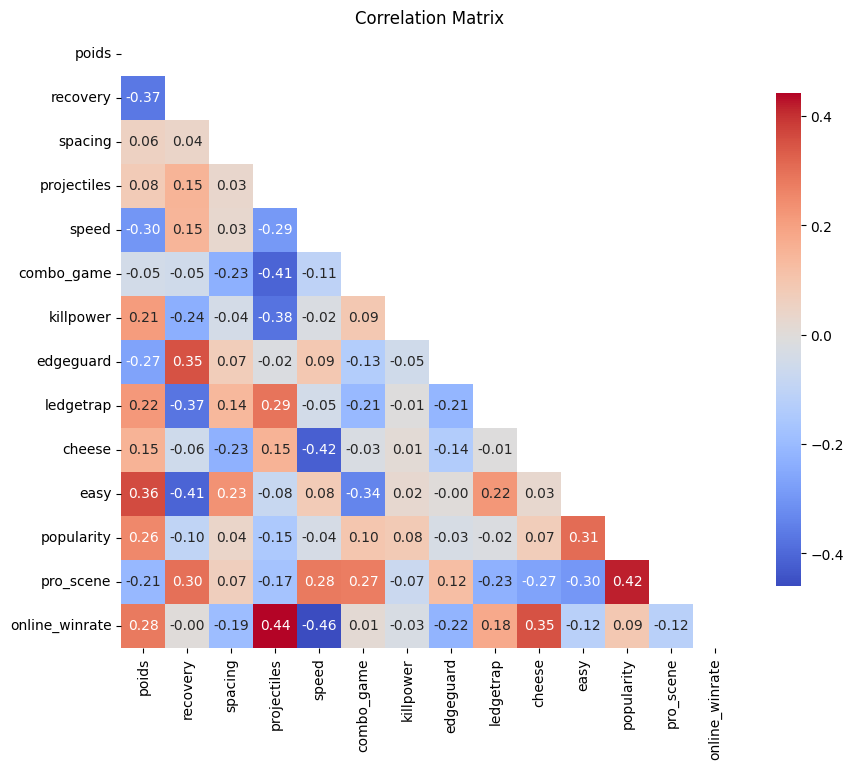

In [3]:
correlation_matrix = df.corr()

# Create a mask to hide the upper triangle of the correlation matrix
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

plt.figure(figsize=(10, 8))
# Plot the heatmap with the mask and correct aspect ratio
sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Correlation Matrix')
plt.show()

In [4]:
# not wanted for clustering
# columns_to_drop = ['popularity', 'online_winrate']  # Add 'easy', 'cheese', 'pro_scene' if needed
# df = drop_columns(df, columns_to_drop)

In [5]:
def calculate_clustering_metrics(df, k_range):
    """Calculate KMeans clustering metrics over a range of k values."""
    sse = []
    silhouette_scores = []
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        clusters = kmeans.fit_predict(df)
        sse.append(kmeans.inertia_)
        silhouette = silhouette_score(df, clusters)
        silhouette_scores.append(silhouette)
    return sse, silhouette_scores

def plot_metrics(k_range, sse, silhouette_scores):
    """Plot SSE and Silhouette Scores to help determine the optimal number of clusters."""
    plt.figure(figsize=(10, 6))
    plt.plot(k_range, sse, marker='o')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Sum of Squared Distances')
    plt.title('Elbow Method For Optimal k')
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.plot(k_range, silhouette_scores, marker='o')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Scores For Different k')
    plt.show()

def perform_clustering(df, n_clusters):
    """Perform KMeans clustering and add cluster assignments back to DataFrame."""
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(df)
    df['Cluster'] = clusters
    return df

def apply_dbscan(df, eps=0.5, min_samples=5):
    """Apply DBSCAN clustering to DataFrame."""
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(df)
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    clusters = dbscan.fit_predict(data_scaled)
    df['Cluster'] = clusters
    return df, clusters

def plot_dbscan_results(df, clusters):
    """Plot DBSCAN results."""
    plt.scatter(df.iloc[:, 0], df.iloc[:, 1], c=clusters, cmap='viridis', marker='o', alpha=0.5)
    plt.title('DBSCAN Clustering')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.colorbar(label='Cluster')
    plt.show()

def print_clusters(df):
    """Print each cluster and its characters."""
    cluster_groups = df.groupby('Cluster')['Cluster'].apply(lambda x: list(x.index))
    for cluster, characters in cluster_groups.items():
        print(f"Cluster {cluster}: {', '.join(characters)}")
        print()

        
# I did not manage to get proper clusters that make sense. Abandonned.

# DBSCAN Clustering
# df, clusters = apply_dbscan(df, eps=2.4, min_samples=3)
# plot_dbscan_results(df, clusters)

# KNN Clustering
# k_range = range(2, 15)
# sse, silhouette_scores = calculate_clustering_metrics(df, k_range)
# plot_metrics(k_range, sse, silhouette_scores)

print("Clusters are not really satisfying, to review later.")
print()
print()

n_clusters = 6
df = perform_clustering(df, n_clusters)
display(df.head())
print_clusters(df)

Clusters are not really satisfying, to review later.




,poids,recovery,spacing,projectiles,speed,combo_game,killpower,edgeguard,ledgetrap,cheese,easy,popularity,pro_scene,online_winrate,Cluster
name,,,,,,,,,,,,,,,
Mario,0.493151,0.375,0.00,0.333333,0.500,0.538462,0.470588,0.277778,0.300,0.4,0.827842,0.386534,0.7,0.446222,3
Donkey Kong,0.890411,0.125,0.50,0.000000,0.625,0.500000,0.862745,0.259259,0.425,1.0,0.876340,0.391521,0.2,0.620889,1
Link,0.575342,0.500,0.75,1.000000,0.375,0.192308,0.568627,0.240741,0.525,0.2,0.482454,0.349127,0.4,0.482222,2
Samus,0.630137,0.625,0.25,1.000000,0.375,0.115385,0.274510,0.407407,0.675,0.4,0.722526,0.498753,0.7,0.612444,2
Yoshi,0.575342,0.750,0.00,0.333333,0.625,0.346154,0.568627,0.314815,0.275,0.4,0.798536,0.433915,0.7,0.580889,5


Cluster 0: Sheik, Lucina, Marth, Meta Knight, Pit, Zero Suit Samus, Wario, Pokemon Trainer, Diddy Kong, Sonic, Greninja, Shulk, Joker

Cluster 1: Donkey Kong, Kirby, Ness, Zelda, Dr. Mario, Ganondorf, King Dedede, Villager, Wii Fit Trainer, Little Mac, Mii Swordfighter, Bowser Jr., Ridley, Simon, King K. Rool, Isabelle, Incineroar, Piranha Plant, Hero, Banjo & Kazooie, Min Min

Cluster 2: Link, Samus, Peach, Young Link, Mewtwo, Olimar, Toon Link, Megaman, Rosalina & Luma, Mii Gunner, Robin, Duck Hunt

Cluster 3: Mario, Captain Falcon, Bowser, Falco, Roy, Chrom, Ike, Wolf, Palutena, Cloud, Corrin, Byleth, Sephiroth, Pyra Mythra, Sora

Cluster 4: Fox, Luigi, Ice Climbers, Ryu, Ken, Terry, Steve, Kazuya

Cluster 5: Yoshi, Pikachu, Jigglypuff, Pichu, Mr. Game & Watch, Snake, Lucas, Lucario, R.O.B., Mii Brawler, Pac-Man, Bayonetta, Inkling



C:\Users\Gais\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


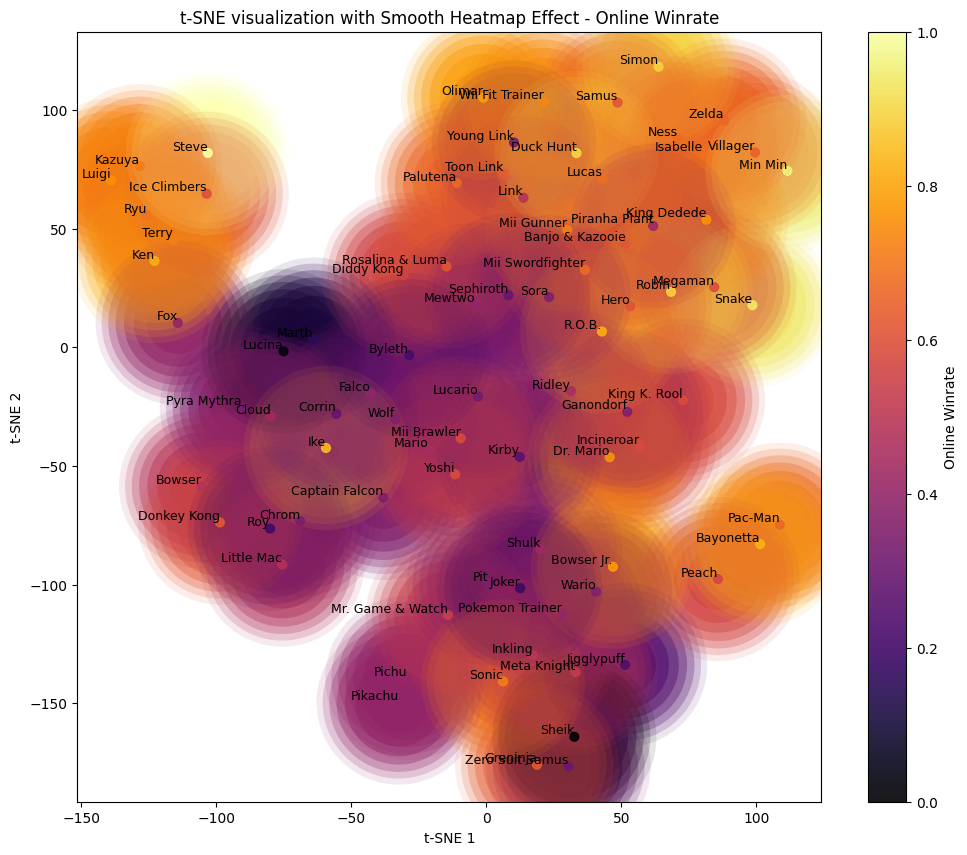

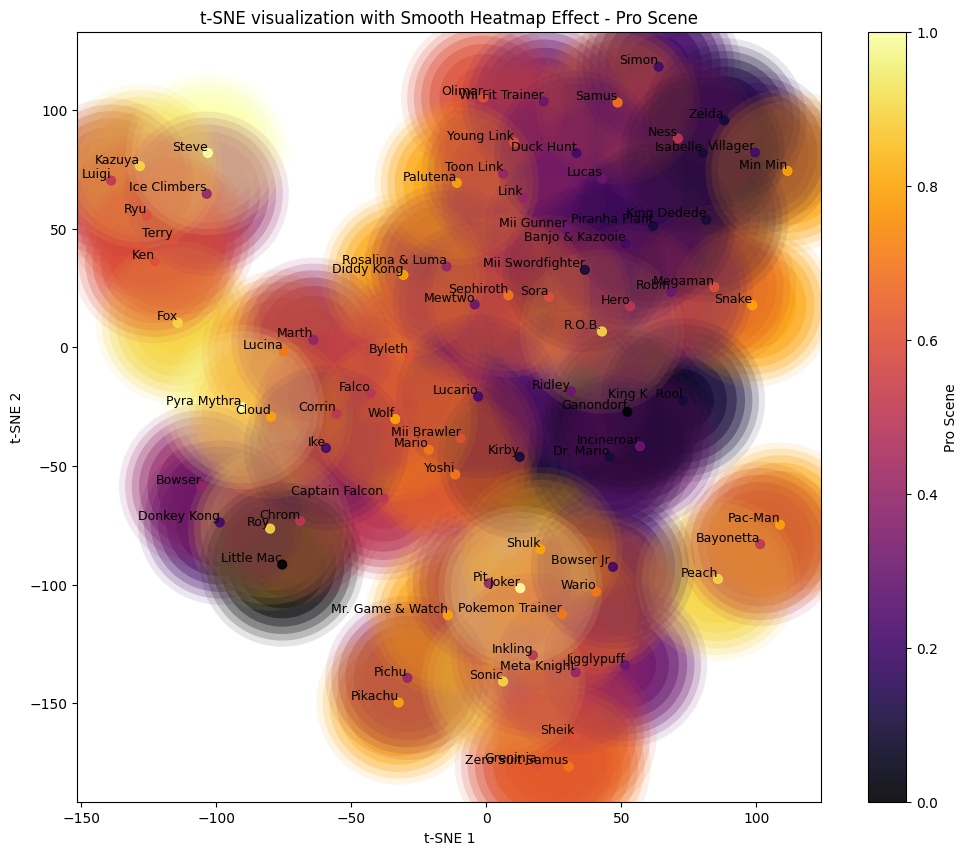

In [6]:
def prepare_data(df, columns_to_drop):
    """Standardize the data excluding the specified columns. Works on a copy to keep original DataFrame intact."""
    df_copy = df.copy()  # Create a copy of the DataFrame to keep original DataFrame unchanged
    df_copy.index.name = 'name'
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(df_copy.drop(columns_to_drop, axis=1))
    return data_scaled

def compute_tsne(data_scaled, n_components=2, perplexity=10, learning_rate=200, n_iter=10000, random_state=42):
    """Compute t-SNE embedding of the dataset."""
    tsne = TSNE(n_components=n_components, perplexity=perplexity, learning_rate=learning_rate, n_iter=n_iter, random_state=random_state)
    tsne_results = tsne.fit_transform(data_scaled)
    return tsne_results

def plot_tsne_heatmap(tsne_results, labels, names, label_name, glow_size_factor=1.0, title='t-SNE Heatmap Visualization'):
    """Plot t-SNE results with smooth color erosion."""
    cmap = plt.cm.inferno  # High-contrast colormap
    norm = Normalize(vmin=min(labels), vmax=max(labels))  # Normalize color scale

    plt.figure(figsize=(12, 10))
    # Fine-tuned glow effect
    num_layers = 7  # Increased number of layers for smoother gradient
    base_size = 20  # Starting size for the smallest layer
    alpha_values = np.linspace(0.6, 0.1, num_layers)  # Linear space for alpha values
    sizes = [base_size * (i + 1) * glow_size_factor for i in range(num_layers)]  # Incremental sizes

    for size, alpha in zip(sizes, alpha_values):
        plt.scatter(tsne_results[:, 0], tsne_results[:, 1], s=size, c=labels, cmap=cmap, norm=norm, alpha=alpha, edgecolor='none')

    # Main scatter plot for the actual points with labels
    scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], s=40, c=labels, cmap=cmap, norm=norm, alpha=0.9)

    # Adding labels to each point
    for i, txt in enumerate(names):
        plt.annotate(txt, (tsne_results[i, 0], tsne_results[i, 1]), fontsize=9, ha='right', va='bottom')

    plt.colorbar(scatter, label=label_name)
    plt.title(title)
    plt.xlabel('t-SNE 1')
    plt.ylabel('t-SNE 2')
    plt.show()

# Example usage
columns_to_drop = ['Cluster', 'popularity', 'pro_scene', 'online_winrate']
data_scaled = prepare_data(df, columns_to_drop)
tsne_results = compute_tsne(data_scaled)

# Plot for online winrate
plot_tsne_heatmap(tsne_results, df['online_winrate'], df.index, 'Online Winrate', glow_size_factor=100, title='t-SNE visualization with Smooth Heatmap Effect - Online Winrate')

# Plot for pro scene
plot_tsne_heatmap(tsne_results, df['pro_scene'], df.index, 'Pro Scene', glow_size_factor=100, title='t-SNE visualization with Smooth Heatmap Effect - Pro Scene')

In [8]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from scipy.spatial import distance

def drop_columns(df, columns_to_drop):
    """Drop specified columns from DataFrame and return new DataFrame."""
    return df.drop(columns=columns_to_drop)

def find_closest_characters(df, character_name, top_n=5):
    """
    Finds the closest characters in the dataset based on Euclidean distance.
    Args:
    df (pd.DataFrame): DataFrame containing all characters and their features.
    character_name (str): Name of the character to find the closest matches for.
    top_n (int): Number of closest characters to return.

    Returns:
    pd.DataFrame: DataFrame containing the details and distances of the closest characters.
    """
    # Normalize the data
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df)
    df_scaled = pd.DataFrame(df_scaled, columns=df.columns, index=df.index)  # Preserve the index

    # Select the target character features
    target_character = df_scaled.loc[character_name]

    # Calculate the Euclidean distances from the target to all others
    distances = df_scaled.apply(lambda x: distance.euclidean(x, target_character), axis=1)

    # Ignore the self distance by setting it to infinity
    distances[character_name] = float('inf')

    # Find the indices of the top_n closest characters
    closest_indices = distances.nsmallest(top_n).index
    closest_distances = distances.loc[closest_indices]

    # Return the details of the closest characters, include distances
    result = df.loc[closest_indices].copy()
    result['Distance'] = closest_distances.values

    return result

# Example usage
columns_to_drop = ['popularity', 'online_winrate', 'pro_scene', 'Cluster']  # Adjust as needed
df = drop_columns(df, columns_to_drop)

# Loop through each character in the DataFrame and perform the analysis
for character_name in df.index:
    closest_characters = find_closest_characters(df, character_name)
    print(f"Details of the given character '{character_name}':")
    display(df.loc[character_name])
    print(f"\nThe {closest_characters.shape[0]} closest characters to '{character_name}' along with their distances are:")
    display(closest_characters)
    
    # Save each result to a CSV file named after the character
    closest_characters.to_csv(f'comparaisons/closest_to_{character_name}.csv')

Details of the given character 'Mario':


poids          0.493151
recovery       0.375000
spacing        0.000000
projectiles    0.333333
speed          0.500000
combo_game     0.538462
killpower      0.470588
edgeguard      0.277778
ledgetrap      0.300000
cheese         0.400000
easy           0.827842
Name: Mario, dtype: float64


The 5 closest characters to 'Mario' along with their distances are:


,poids,recovery,spacing,projectiles,speed,combo_game,killpower,edgeguard,ledgetrap,cheese,easy,Distance
name,,,,,,,,,,,,
Mii Brawler,0.438356,0.500,0.00,0.333333,0.500,0.384615,0.568627,0.129630,0.300,0.6,0.699461,1.559960
Yoshi,0.575342,0.750,0.00,0.333333,0.625,0.346154,0.568627,0.314815,0.275,0.4,0.798536,1.919027
Wolf,0.410959,0.500,0.50,0.333333,0.500,0.461538,0.647059,0.388889,0.375,0.4,0.769671,1.976733
Ridley,0.616438,0.250,0.50,0.333333,0.500,0.269231,0.549020,0.425926,0.300,0.8,0.734730,2.706367
Wario,0.630137,0.625,0.25,0.333333,0.375,0.576923,0.647059,0.574074,0.225,0.4,0.466675,2.708743


Details of the given character 'Donkey Kong':


poids          0.890411
recovery       0.125000
spacing        0.500000
projectiles    0.000000
speed          0.625000
combo_game     0.500000
killpower      0.862745
edgeguard      0.259259
ledgetrap      0.425000
cheese         1.000000
easy           0.876340
Name: Donkey Kong, dtype: float64


The 5 closest characters to 'Donkey Kong' along with their distances are:


,poids,recovery,spacing,projectiles,speed,combo_game,killpower,edgeguard,ledgetrap,cheese,easy,Distance
name,,,,,,,,,,,,
Roy,0.452055,0.250,0.75,0.000000,0.750,0.423077,0.784314,0.185185,0.425,0.8,0.741773,2.804638
Incineroar,0.739726,0.125,0.25,0.000000,0.000,0.423077,0.725490,0.259259,0.525,1.0,0.741651,3.070058
Ridley,0.616438,0.250,0.50,0.333333,0.500,0.269231,0.549020,0.425926,0.300,0.8,0.734730,3.107006
Bowser,1.000000,0.250,0.50,0.333333,0.625,0.384615,0.627451,0.259259,0.525,0.2,0.984310,3.268293
Ganondorf,0.767123,0.000,0.25,0.000000,0.125,0.230769,0.568627,0.203704,0.200,0.8,0.940331,3.520309


Details of the given character 'Link':


poids          0.575342
recovery       0.500000
spacing        0.750000
projectiles    1.000000
speed          0.375000
combo_game     0.192308
killpower      0.568627
edgeguard      0.240741
ledgetrap      0.525000
cheese         0.200000
easy           0.482454
Name: Link, dtype: float64


The 5 closest characters to 'Link' along with their distances are:


,poids,recovery,spacing,projectiles,speed,combo_game,killpower,edgeguard,ledgetrap,cheese,easy,Distance
name,,,,,,,,,,,,
Toon Link,0.397260,0.500,0.50,1.000000,0.500,0.192308,0.470588,0.314815,0.475,0.2,0.661764,1.649967
Mii Swordfighter,0.520548,0.625,0.75,0.666667,0.375,0.307692,0.450980,0.351852,0.400,0.6,0.775963,2.446267
Banjo & Kazooie,0.602740,0.375,0.50,1.000000,0.375,0.153846,0.392157,0.351852,0.275,0.6,0.671272,2.549353
Robin,0.452055,0.625,0.75,1.000000,0.125,0.153846,0.647059,0.314815,0.250,0.6,0.373560,2.616009
Young Link,0.356164,0.500,0.50,1.000000,0.500,0.423077,0.274510,0.148148,0.400,0.2,0.657535,2.696064


Details of the given character 'Samus':


poids          0.630137
recovery       0.625000
spacing        0.250000
projectiles    1.000000
speed          0.375000
combo_game     0.115385
killpower      0.274510
edgeguard      0.407407
ledgetrap      0.675000
cheese         0.400000
easy           0.722526
Name: Samus, dtype: float64


The 5 closest characters to 'Samus' along with their distances are:


,poids,recovery,spacing,projectiles,speed,combo_game,killpower,edgeguard,ledgetrap,cheese,easy,Distance
name,,,,,,,,,,,,
Toon Link,0.397260,0.500,0.50,1.000000,0.500,0.192308,0.470588,0.314815,0.475,0.2,0.661764,2.432777
Ness,0.438356,0.500,0.25,0.666667,0.250,0.230769,0.549020,0.351852,0.575,0.8,0.703442,2.633104
Link,0.575342,0.500,0.75,1.000000,0.375,0.192308,0.568627,0.240741,0.525,0.2,0.482454,2.741616
Banjo & Kazooie,0.602740,0.375,0.50,1.000000,0.375,0.153846,0.392157,0.351852,0.275,0.6,0.671272,2.878641
Palutena,0.397260,0.500,0.50,0.666667,0.625,0.346154,0.509804,0.481481,0.600,0.2,0.884630,2.918455


Details of the given character 'Yoshi':


poids          0.575342
recovery       0.750000
spacing        0.000000
projectiles    0.333333
speed          0.625000
combo_game     0.346154
killpower      0.568627
edgeguard      0.314815
ledgetrap      0.275000
cheese         0.400000
easy           0.798536
Name: Yoshi, dtype: float64


The 5 closest characters to 'Yoshi' along with their distances are:


,poids,recovery,spacing,projectiles,speed,combo_game,killpower,edgeguard,ledgetrap,cheese,easy,Distance
name,,,,,,,,,,,,
Mii Brawler,0.438356,0.500,0.00,0.333333,0.500,0.384615,0.568627,0.129630,0.300,0.6,0.699461,1.747719
Mario,0.493151,0.375,0.00,0.333333,0.500,0.538462,0.470588,0.277778,0.300,0.4,0.827842,1.919027
Wolf,0.410959,0.500,0.50,0.333333,0.500,0.461538,0.647059,0.388889,0.375,0.4,0.769671,2.223564
Inkling,0.438356,1.000,0.00,0.333333,0.625,0.500000,0.647059,0.685185,0.200,0.6,0.625689,2.532594
Wario,0.630137,0.625,0.25,0.333333,0.375,0.576923,0.647059,0.574074,0.225,0.4,0.466675,2.665004


Details of the given character 'Kirby':


poids          0.232877
recovery       0.250000
spacing        0.000000
projectiles    0.000000
speed          0.250000
combo_game     0.423077
killpower      0.352941
edgeguard      0.351852
ledgetrap      0.150000
cheese         0.800000
easy           0.902752
Name: Kirby, dtype: float64


The 5 closest characters to 'Kirby' along with their distances are:


,poids,recovery,spacing,projectiles,speed,combo_game,killpower,edgeguard,ledgetrap,cheese,easy,Distance
name,,,,,,,,,,,,
Mario,0.493151,0.375,0.0,0.333333,0.500,0.538462,0.470588,0.277778,0.300,0.4,0.827842,2.783877
Mii Brawler,0.438356,0.500,0.0,0.333333,0.500,0.384615,0.568627,0.129630,0.300,0.6,0.699461,2.890550
Dr. Mario,0.493151,0.000,0.0,0.333333,0.125,0.423077,0.607843,0.444444,0.450,1.0,0.692540,3.223076
Ridley,0.616438,0.250,0.5,0.333333,0.500,0.269231,0.549020,0.425926,0.300,0.8,0.734730,3.392524
Wolf,0.410959,0.500,0.5,0.333333,0.500,0.461538,0.647059,0.388889,0.375,0.4,0.769671,3.453826


Details of the given character 'Fox':


poids          0.205479
recovery       0.250000
spacing        0.000000
projectiles    0.333333
speed          0.875000
combo_game     0.576923
killpower      0.803922
edgeguard      0.037037
ledgetrap      0.350000
cheese         0.400000
easy           0.346694
Name: Fox, dtype: float64


The 5 closest characters to 'Fox' along with their distances are:


,poids,recovery,spacing,projectiles,speed,combo_game,killpower,edgeguard,ledgetrap,cheese,easy,Distance
name,,,,,,,,,,,,
Mii Brawler,0.438356,0.500,0.0,0.333333,0.500,0.384615,0.568627,0.129630,0.300,0.6,0.699461,3.196400
Falco,0.273973,0.250,0.5,0.666667,0.500,0.538462,0.666667,0.462963,0.275,0.2,0.527785,3.360775
Ken,0.561644,0.375,0.0,0.333333,0.375,0.576923,1.000000,0.111111,0.525,0.2,0.178378,3.397037
Ryu,0.561644,0.375,0.0,0.333333,0.250,0.576923,0.666667,0.018519,0.175,0.4,0.181473,3.602284
Greninja,0.356164,0.875,0.5,0.333333,0.875,0.307692,0.725490,0.296296,0.350,0.0,0.377885,3.632722


Details of the given character 'Pikachu':


poids          0.232877
recovery       1.000000
spacing        0.000000
projectiles    0.666667
speed          0.625000
combo_game     0.269231
killpower      0.333333
edgeguard      0.685185
ledgetrap      0.175000
cheese         1.000000
easy           0.341482
Name: Pikachu, dtype: float64


The 5 closest characters to 'Pikachu' along with their distances are:


,poids,recovery,spacing,projectiles,speed,combo_game,killpower,edgeguard,ledgetrap,cheese,easy,Distance
name,,,,,,,,,,,,
Pichu,0.000000,1.000,0.00,0.333333,0.500,0.423077,0.470588,0.592593,0.250,1.0,0.342654,2.092745
Lucas,0.438356,0.625,0.25,0.666667,0.375,0.346154,0.235294,0.537037,0.325,0.6,0.566364,2.996180
Inkling,0.438356,1.000,0.00,0.333333,0.625,0.500000,0.647059,0.685185,0.200,0.6,0.625689,3.055511
Pac-Man,0.452055,1.000,0.00,0.666667,0.375,0.576923,0.176471,0.277778,0.225,1.0,0.231614,3.157855
Megaman,0.547945,0.875,0.25,1.000000,0.500,0.076923,0.549020,0.444444,0.300,0.6,0.321185,3.271829


Details of the given character 'Luigi':


poids          0.479452
recovery       0.250000
spacing        0.000000
projectiles    0.333333
speed          0.250000
combo_game     0.769231
killpower      0.980392
edgeguard      0.166667
ledgetrap      0.150000
cheese         1.000000
easy           0.443963
Name: Luigi, dtype: float64


The 5 closest characters to 'Luigi' along with their distances are:


,poids,recovery,spacing,projectiles,speed,combo_game,killpower,edgeguard,ledgetrap,cheese,easy,Distance
name,,,,,,,,,,,,
Kazuya,0.698630,0.500,0.0,0.333333,0.000,1.000000,0.901961,0.111111,0.200,0.8,0.132400,2.704321
Ryu,0.561644,0.375,0.0,0.333333,0.250,0.576923,0.666667,0.018519,0.175,0.4,0.181473,3.084472
Terry,0.630137,0.250,0.0,0.333333,0.250,0.692308,0.725490,0.148148,0.525,0.4,0.409790,3.415850
Steve,0.410959,0.875,0.5,0.000000,0.000,0.576923,0.745098,0.185185,0.275,1.0,0.229489,3.606576
Dr. Mario,0.493151,0.000,0.0,0.333333,0.125,0.423077,0.607843,0.444444,0.450,1.0,0.692540,3.782472


Details of the given character 'Ness':


poids          0.438356
recovery       0.500000
spacing        0.250000
projectiles    0.666667
speed          0.250000
combo_game     0.230769
killpower      0.549020
edgeguard      0.351852
ledgetrap      0.575000
cheese         0.800000
easy           0.703442
Name: Ness, dtype: float64


The 5 closest characters to 'Ness' along with their distances are:


,poids,recovery,spacing,projectiles,speed,combo_game,killpower,edgeguard,ledgetrap,cheese,easy,Distance
name,,,,,,,,,,,,
Isabelle,0.356164,0.500,0.00,1.000000,0.250,0.307692,0.549020,0.370370,0.475,0.8,0.630153,1.504965
Zelda,0.315068,0.750,0.25,1.000000,0.250,0.076923,0.784314,0.277778,0.500,0.8,0.719762,2.143397
Mii Swordfighter,0.520548,0.625,0.75,0.666667,0.375,0.307692,0.450980,0.351852,0.400,0.6,0.775963,2.184357
Piranha Plant,0.684932,0.375,0.50,1.000000,0.250,0.307692,0.352941,0.314815,0.400,1.0,0.641127,2.497314
Villager,0.410959,0.500,0.00,1.000000,0.250,0.038462,0.705882,0.666667,0.450,0.6,0.596051,2.564392


Details of the given character 'Captain Falcon':


poids          0.575342
recovery       0.250000
spacing        0.000000
projectiles    0.000000
speed          0.750000
combo_game     0.346154
killpower      0.568627
edgeguard      0.425926
ledgetrap      0.525000
cheese         0.200000
easy           0.603246
Name: Captain Falcon, dtype: float64


The 5 closest characters to 'Captain Falcon' along with their distances are:


,poids,recovery,spacing,projectiles,speed,combo_game,killpower,edgeguard,ledgetrap,cheese,easy,Distance
name,,,,,,,,,,,,
Mario,0.493151,0.375,0.00,0.333333,0.500,0.538462,0.470588,0.277778,0.300,0.4,0.827842,2.728690
Chrom,0.452055,0.125,0.75,0.000000,0.750,0.307692,0.784314,0.296296,0.600,0.4,0.782628,2.816719
Wolf,0.410959,0.500,0.50,0.333333,0.500,0.461538,0.647059,0.388889,0.375,0.4,0.769671,2.819381
Yoshi,0.575342,0.750,0.00,0.333333,0.625,0.346154,0.568627,0.314815,0.275,0.4,0.798536,2.841996
Mii Brawler,0.438356,0.500,0.00,0.333333,0.500,0.384615,0.568627,0.129630,0.300,0.6,0.699461,3.024241


Details of the given character 'Jigglypuff':


poids          0.082192
recovery       0.375000
spacing        0.000000
projectiles    0.000000
speed          0.125000
combo_game     0.461538
killpower      0.686275
edgeguard      1.000000
ledgetrap      0.050000
cheese         0.400000
easy           0.563185
Name: Jigglypuff, dtype: float64


The 5 closest characters to 'Jigglypuff' along with their distances are:


,poids,recovery,spacing,projectiles,speed,combo_game,killpower,edgeguard,ledgetrap,cheese,easy,Distance
name,,,,,,,,,,,,
Meta Knight,0.246575,1.000,0.25,0.000000,0.625,0.500000,0.843137,0.759259,0.250,0.2,0.430117,3.858735
Kirby,0.232877,0.250,0.00,0.000000,0.250,0.423077,0.352941,0.351852,0.150,0.8,0.902752,4.168913
Inkling,0.438356,1.000,0.00,0.333333,0.625,0.500000,0.647059,0.685185,0.200,0.6,0.625689,4.207398
Joker,0.424658,0.875,0.75,0.333333,0.500,0.307692,0.529412,0.740741,0.150,0.4,0.460078,4.236789
Wario,0.630137,0.625,0.25,0.333333,0.375,0.576923,0.647059,0.574074,0.225,0.4,0.466675,4.243338


Details of the given character 'Peach':


poids          0.369863
recovery       0.750000
spacing        0.500000
projectiles    0.666667
speed          0.250000
combo_game     0.769231
killpower      0.254902
edgeguard      0.648148
ledgetrap      0.400000
cheese         0.200000
easy           0.073293
Name: Peach, dtype: float64


The 5 closest characters to 'Peach' along with their distances are:


,poids,recovery,spacing,projectiles,speed,combo_game,killpower,edgeguard,ledgetrap,cheese,easy,Distance
name,,,,,,,,,,,,
Pokemon Trainer,0.465753,0.875,0.50,0.333333,0.500,0.538462,0.588235,0.685185,0.225,0.2,0.305465,2.995511
Bayonetta,0.260274,0.750,0.25,0.333333,0.375,0.769231,0.176471,0.314815,0.275,0.8,0.285613,3.143294
Duck Hunt,0.328767,0.750,0.50,1.000000,0.500,0.384615,0.000000,0.407407,0.400,0.6,0.326892,3.495202
Olimar,0.232877,0.750,0.50,1.000000,0.125,0.461538,0.333333,0.240741,0.575,0.6,0.353384,3.552713
Lucas,0.438356,0.625,0.25,0.666667,0.375,0.346154,0.235294,0.537037,0.325,0.6,0.566364,3.578443


Details of the given character 'Bowser':


poids          1.000000
recovery       0.250000
spacing        0.500000
projectiles    0.333333
speed          0.625000
combo_game     0.384615
killpower      0.627451
edgeguard      0.259259
ledgetrap      0.525000
cheese         0.200000
easy           0.984310
Name: Bowser, dtype: float64


The 5 closest characters to 'Bowser' along with their distances are:


,poids,recovery,spacing,projectiles,speed,combo_game,killpower,edgeguard,ledgetrap,cheese,easy,Distance
name,,,,,,,,,,,,
Donkey Kong,0.890411,0.125,0.50,0.000000,0.625,0.500000,0.862745,0.259259,0.425,1.0,0.876340,3.268293
Captain Falcon,0.575342,0.250,0.00,0.000000,0.750,0.346154,0.568627,0.425926,0.525,0.2,0.603246,3.428764
Cloud,0.520548,0.125,1.00,0.333333,0.625,0.538462,0.431373,0.296296,0.375,0.2,0.878188,3.430194
Ridley,0.616438,0.250,0.50,0.333333,0.500,0.269231,0.549020,0.425926,0.300,0.8,0.734730,3.554250
Chrom,0.452055,0.125,0.75,0.000000,0.750,0.307692,0.784314,0.296296,0.600,0.4,0.782628,3.598648


Details of the given character 'Ice Climbers':


poids          0.410959
recovery       0.375000
spacing        0.500000
projectiles    0.333333
speed          0.125000
combo_game     0.807692
killpower      0.470588
edgeguard      0.000000
ledgetrap      0.500000
cheese         0.800000
easy           0.000000
Name: Ice Climbers, dtype: float64


The 5 closest characters to 'Ice Climbers' along with their distances are:


,poids,recovery,spacing,projectiles,speed,combo_game,killpower,edgeguard,ledgetrap,cheese,easy,Distance
name,,,,,,,,,,,,
Terry,0.630137,0.250,0.00,0.333333,0.250,0.692308,0.725490,0.148148,0.525,0.4,0.409790,3.318500
Ryu,0.561644,0.375,0.00,0.333333,0.250,0.576923,0.666667,0.018519,0.175,0.4,0.181473,3.431638
Bayonetta,0.260274,0.750,0.25,0.333333,0.375,0.769231,0.176471,0.314815,0.275,0.8,0.285613,3.433412
Steve,0.410959,0.875,0.50,0.000000,0.000,0.576923,0.745098,0.185185,0.275,1.0,0.229489,3.442292
Olimar,0.232877,0.750,0.50,1.000000,0.125,0.461538,0.333333,0.240741,0.575,0.6,0.353384,3.805095


Details of the given character 'Sheik':


poids          0.219178
recovery       0.875000
spacing        0.250000
projectiles    0.333333
speed          0.875000
combo_game     0.307692
killpower      0.647059
edgeguard      0.611111
ledgetrap      0.300000
cheese         0.000000
easy           0.091348
Name: Sheik, dtype: float64


The 5 closest characters to 'Sheik' along with their distances are:


,poids,recovery,spacing,projectiles,speed,combo_game,killpower,edgeguard,ledgetrap,cheese,easy,Distance
name,,,,,,,,,,,,
Zero Suit Samus,0.246575,1.000,0.50,0.333333,0.875,0.230769,0.725490,0.481481,0.375,0.0,0.301476,1.545843
Greninja,0.356164,0.875,0.50,0.333333,0.875,0.307692,0.725490,0.296296,0.350,0.0,0.377885,2.214966
Meta Knight,0.246575,1.000,0.25,0.000000,0.625,0.500000,0.843137,0.759259,0.250,0.2,0.430117,2.696204
Pokemon Trainer,0.465753,0.875,0.50,0.333333,0.500,0.538462,0.588235,0.685185,0.225,0.2,0.305465,2.830934
Marth,0.383562,0.625,1.00,0.000000,0.750,0.346154,0.529412,0.518519,0.250,0.2,0.491273,3.334093


Details of the given character 'Zelda':


poids          0.315068
recovery       0.750000
spacing        0.250000
projectiles    1.000000
speed          0.250000
combo_game     0.076923
killpower      0.784314
edgeguard      0.277778
ledgetrap      0.500000
cheese         0.800000
easy           0.719762
Name: Zelda, dtype: float64


The 5 closest characters to 'Zelda' along with their distances are:


,poids,recovery,spacing,projectiles,speed,combo_game,killpower,edgeguard,ledgetrap,cheese,easy,Distance
name,,,,,,,,,,,,
Ness,0.438356,0.500,0.25,0.666667,0.250,0.230769,0.549020,0.351852,0.575,0.8,0.703442,2.143397
Isabelle,0.356164,0.500,0.00,1.000000,0.250,0.307692,0.549020,0.370370,0.475,0.8,0.630153,2.163432
Villager,0.410959,0.500,0.00,1.000000,0.250,0.038462,0.705882,0.666667,0.450,0.6,0.596051,2.432169
Hero,0.534247,0.750,0.75,0.666667,0.375,0.192308,0.686275,0.277778,0.250,1.0,0.626596,2.861638
Robin,0.452055,0.625,0.75,1.000000,0.125,0.153846,0.647059,0.314815,0.250,0.6,0.373560,2.922051


Details of the given character 'Dr. Mario':


poids          0.493151
recovery       0.000000
spacing        0.000000
projectiles    0.333333
speed          0.125000
combo_game     0.423077
killpower      0.607843
edgeguard      0.444444
ledgetrap      0.450000
cheese         1.000000
easy           0.692540
Name: Dr. Mario, dtype: float64


The 5 closest characters to 'Dr. Mario' along with their distances are:


,poids,recovery,spacing,projectiles,speed,combo_game,killpower,edgeguard,ledgetrap,cheese,easy,Distance
name,,,,,,,,,,,,
Incineroar,0.739726,0.125,0.25,0.000000,0.000,0.423077,0.725490,0.259259,0.525,1.0,0.741651,2.248219
Ness,0.438356,0.500,0.25,0.666667,0.250,0.230769,0.549020,0.351852,0.575,0.8,0.703442,2.713342
Ridley,0.616438,0.250,0.50,0.333333,0.500,0.269231,0.549020,0.425926,0.300,0.8,0.734730,2.801721
Isabelle,0.356164,0.500,0.00,1.000000,0.250,0.307692,0.549020,0.370370,0.475,0.8,0.630153,2.963491
Ganondorf,0.767123,0.000,0.25,0.000000,0.125,0.230769,0.568627,0.203704,0.200,0.8,0.940331,3.146429


Details of the given character 'Pichu':


poids          0.000000
recovery       1.000000
spacing        0.000000
projectiles    0.333333
speed          0.500000
combo_game     0.423077
killpower      0.470588
edgeguard      0.592593
ledgetrap      0.250000
cheese         1.000000
easy           0.342654
Name: Pichu, dtype: float64


The 5 closest characters to 'Pichu' along with their distances are:


,poids,recovery,spacing,projectiles,speed,combo_game,killpower,edgeguard,ledgetrap,cheese,easy,Distance
name,,,,,,,,,,,,
Pikachu,0.232877,1.00,0.00,0.666667,0.625,0.269231,0.333333,0.685185,0.175,1.0,0.341482,2.092745
Mr. Game & Watch,0.178082,1.00,0.75,0.333333,0.500,0.538462,0.352941,0.703704,0.175,0.8,0.759588,3.172418
Inkling,0.438356,1.00,0.00,0.333333,0.625,0.500000,0.647059,0.685185,0.200,0.6,0.625689,3.208506
Bayonetta,0.260274,0.75,0.25,0.333333,0.375,0.769231,0.176471,0.314815,0.275,0.8,0.285613,3.400291
Pac-Man,0.452055,1.00,0.00,0.666667,0.375,0.576923,0.176471,0.277778,0.225,1.0,0.231614,3.545121


Details of the given character 'Falco':


poids          0.273973
recovery       0.250000
spacing        0.500000
projectiles    0.666667
speed          0.500000
combo_game     0.538462
killpower      0.666667
edgeguard      0.462963
ledgetrap      0.275000
cheese         0.200000
easy           0.527785
Name: Falco, dtype: float64


The 5 closest characters to 'Falco' along with their distances are:


,poids,recovery,spacing,projectiles,speed,combo_game,killpower,edgeguard,ledgetrap,cheese,easy,Distance
name,,,,,,,,,,,,
Wolf,0.410959,0.500,0.50,0.333333,0.500,0.461538,0.647059,0.388889,0.375,0.4,0.769671,2.090542
Corrin,0.493151,0.375,1.00,0.333333,0.375,0.538462,0.647059,0.407407,0.225,0.2,0.686925,2.327732
Wario,0.630137,0.625,0.25,0.333333,0.375,0.576923,0.647059,0.574074,0.225,0.4,0.466675,2.855806
Mario,0.493151,0.375,0.00,0.333333,0.500,0.538462,0.470588,0.277778,0.300,0.4,0.827842,2.872079
Toon Link,0.397260,0.500,0.50,1.000000,0.500,0.192308,0.470588,0.314815,0.475,0.2,0.661764,3.001099


Details of the given character 'Lucina':


poids          0.383562
recovery       0.625000
spacing        1.000000
projectiles    0.000000
speed          0.750000
combo_game     0.307692
killpower      0.450980
edgeguard      0.518519
ledgetrap      0.350000
cheese         0.000000
easy           0.894961
Name: Lucina, dtype: float64


The 5 closest characters to 'Lucina' along with their distances are:


,poids,recovery,spacing,projectiles,speed,combo_game,killpower,edgeguard,ledgetrap,cheese,easy,Distance
name,,,,,,,,,,,,
Marth,0.383562,0.625,1.00,0.000000,0.750,0.346154,0.529412,0.518519,0.250,0.2,0.491273,1.942126
Pit,0.465753,0.875,0.75,0.333333,0.500,0.346154,0.450980,0.648148,0.125,0.2,0.721039,2.604477
Pyra Mythra,0.452055,0.250,1.00,0.333333,0.875,0.384615,0.352941,0.222222,0.400,0.4,0.943329,2.708293
Cloud,0.520548,0.125,1.00,0.333333,0.625,0.538462,0.431373,0.296296,0.375,0.2,0.878188,2.843034
Wolf,0.410959,0.500,0.50,0.333333,0.500,0.461538,0.647059,0.388889,0.375,0.4,0.769671,2.879796


Details of the given character 'Marth':


poids          0.383562
recovery       0.625000
spacing        1.000000
projectiles    0.000000
speed          0.750000
combo_game     0.346154
killpower      0.529412
edgeguard      0.518519
ledgetrap      0.250000
cheese         0.200000
easy           0.491273
Name: Marth, dtype: float64


The 5 closest characters to 'Marth' along with their distances are:


,poids,recovery,spacing,projectiles,speed,combo_game,killpower,edgeguard,ledgetrap,cheese,easy,Distance
name,,,,,,,,,,,,
Lucina,0.383562,0.625,1.00,0.000000,0.750,0.307692,0.450980,0.518519,0.350,0.0,0.894961,1.942126
Joker,0.424658,0.875,0.75,0.333333,0.500,0.307692,0.529412,0.740741,0.150,0.4,0.460078,2.308362
Pit,0.465753,0.875,0.75,0.333333,0.500,0.346154,0.450980,0.648148,0.125,0.2,0.721039,2.351228
Corrin,0.493151,0.375,1.00,0.333333,0.375,0.538462,0.647059,0.407407,0.225,0.2,0.686925,2.636929
Greninja,0.356164,0.875,0.50,0.333333,0.875,0.307692,0.725490,0.296296,0.350,0.0,0.377885,2.672473


Details of the given character 'Young Link':


poids          0.356164
recovery       0.500000
spacing        0.500000
projectiles    1.000000
speed          0.500000
combo_game     0.423077
killpower      0.274510
edgeguard      0.148148
ledgetrap      0.400000
cheese         0.200000
easy           0.657535
Name: Young Link, dtype: float64


The 5 closest characters to 'Young Link' along with their distances are:


,poids,recovery,spacing,projectiles,speed,combo_game,killpower,edgeguard,ledgetrap,cheese,easy,Distance
name,,,,,,,,,,,,
Toon Link,0.397260,0.500,0.50,1.000000,0.500,0.192308,0.470588,0.314815,0.475,0.2,0.661764,1.854323
Mii Swordfighter,0.520548,0.625,0.75,0.666667,0.375,0.307692,0.450980,0.351852,0.400,0.6,0.775963,2.596832
Link,0.575342,0.500,0.75,1.000000,0.375,0.192308,0.568627,0.240741,0.525,0.2,0.482454,2.696064
Wii Fit Trainer,0.465753,0.375,0.00,0.666667,0.500,0.423077,0.176471,0.092593,0.600,0.6,0.472383,2.753936
Palutena,0.397260,0.500,0.50,0.666667,0.625,0.346154,0.509804,0.481481,0.600,0.2,0.884630,2.767944


Details of the given character 'Ganondorf':


poids          0.767123
recovery       0.000000
spacing        0.250000
projectiles    0.000000
speed          0.125000
combo_game     0.230769
killpower      0.568627
edgeguard      0.203704
ledgetrap      0.200000
cheese         0.800000
easy           0.940331
Name: Ganondorf, dtype: float64


The 5 closest characters to 'Ganondorf' along with their distances are:


,poids,recovery,spacing,projectiles,speed,combo_game,killpower,edgeguard,ledgetrap,cheese,easy,Distance
name,,,,,,,,,,,,
Incineroar,0.739726,0.125,0.25,0.000000,0.000,0.423077,0.725490,0.259259,0.525,1.0,0.741651,2.715200
Ridley,0.616438,0.250,0.50,0.333333,0.500,0.269231,0.549020,0.425926,0.300,0.8,0.734730,2.760037
Dr. Mario,0.493151,0.000,0.00,0.333333,0.125,0.423077,0.607843,0.444444,0.450,1.0,0.692540,3.146429
King K. Rool,0.972603,0.500,0.00,0.666667,0.250,0.346154,0.627451,0.185185,0.375,1.0,1.000000,3.315201
Donkey Kong,0.890411,0.125,0.50,0.000000,0.625,0.500000,0.862745,0.259259,0.425,1.0,0.876340,3.520309


Details of the given character 'Mewtwo':


poids          0.219178
recovery       0.625000
spacing        0.750000
projectiles    0.666667
speed          0.750000
combo_game     0.307692
killpower      0.666667
edgeguard      0.351852
ledgetrap      0.375000
cheese         0.800000
easy           0.506043
Name: Mewtwo, dtype: float64


The 5 closest characters to 'Mewtwo' along with their distances are:


,poids,recovery,spacing,projectiles,speed,combo_game,killpower,edgeguard,ledgetrap,cheese,easy,Distance
name,,,,,,,,,,,,
Sephiroth,0.232877,0.625,1.00,0.666667,0.375,0.192308,0.588235,0.481481,0.325,0.6,0.564348,2.121994
Rosalina & Luma,0.273973,0.625,0.75,0.666667,0.500,0.230769,0.372549,0.166667,0.375,0.6,0.217251,2.480605
Hero,0.534247,0.750,0.75,0.666667,0.375,0.192308,0.686275,0.277778,0.250,1.0,0.626596,2.725264
Wolf,0.410959,0.500,0.50,0.333333,0.500,0.461538,0.647059,0.388889,0.375,0.4,0.769671,2.729300
Lucario,0.410959,1.000,0.25,0.333333,0.625,0.384615,0.705882,0.111111,0.300,0.8,0.434623,2.806497


Details of the given character 'Roy':


poids          0.452055
recovery       0.250000
spacing        0.750000
projectiles    0.000000
speed          0.750000
combo_game     0.423077
killpower      0.784314
edgeguard      0.185185
ledgetrap      0.425000
cheese         0.800000
easy           0.741773
Name: Roy, dtype: float64


The 5 closest characters to 'Roy' along with their distances are:


,poids,recovery,spacing,projectiles,speed,combo_game,killpower,edgeguard,ledgetrap,cheese,easy,Distance
name,,,,,,,,,,,,
Chrom,0.452055,0.125,0.75,0.000000,0.750,0.307692,0.784314,0.296296,0.600,0.4,0.782628,1.941106
Wolf,0.410959,0.500,0.50,0.333333,0.500,0.461538,0.647059,0.388889,0.375,0.4,0.769671,2.573899
Little Mac,0.342466,0.000,0.25,0.000000,0.875,0.192308,0.901961,0.055556,0.575,1.0,0.857517,2.692759
Ridley,0.616438,0.250,0.50,0.333333,0.500,0.269231,0.549020,0.425926,0.300,0.8,0.734730,2.701427
Donkey Kong,0.890411,0.125,0.50,0.000000,0.625,0.500000,0.862745,0.259259,0.425,1.0,0.876340,2.804638


Details of the given character 'Chrom':


poids          0.452055
recovery       0.125000
spacing        0.750000
projectiles    0.000000
speed          0.750000
combo_game     0.307692
killpower      0.784314
edgeguard      0.296296
ledgetrap      0.600000
cheese         0.400000
easy           0.782628
Name: Chrom, dtype: float64


The 5 closest characters to 'Chrom' along with their distances are:


,poids,recovery,spacing,projectiles,speed,combo_game,killpower,edgeguard,ledgetrap,cheese,easy,Distance
name,,,,,,,,,,,,
Roy,0.452055,0.25,0.75,0.000000,0.750,0.423077,0.784314,0.185185,0.425,0.8,0.741773,1.941106
Wolf,0.410959,0.50,0.50,0.333333,0.500,0.461538,0.647059,0.388889,0.375,0.4,0.769671,2.764383
Captain Falcon,0.575342,0.25,0.00,0.000000,0.750,0.346154,0.568627,0.425926,0.525,0.2,0.603246,2.816719
Pyra Mythra,0.452055,0.25,1.00,0.333333,0.875,0.384615,0.352941,0.222222,0.400,0.4,0.943329,2.967885
Little Mac,0.342466,0.00,0.25,0.000000,0.875,0.192308,0.901961,0.055556,0.575,1.0,0.857517,2.973995


Details of the given character 'Mr. Game & Watch':


poids          0.178082
recovery       1.000000
spacing        0.750000
projectiles    0.333333
speed          0.500000
combo_game     0.538462
killpower      0.352941
edgeguard      0.703704
ledgetrap      0.175000
cheese         0.800000
easy           0.759588
Name: Mr. Game & Watch, dtype: float64


The 5 closest characters to 'Mr. Game & Watch' along with their distances are:


,poids,recovery,spacing,projectiles,speed,combo_game,killpower,edgeguard,ledgetrap,cheese,easy,Distance
name,,,,,,,,,,,,
Joker,0.424658,0.875,0.75,0.333333,0.500,0.307692,0.529412,0.740741,0.150,0.4,0.460078,2.769019
Pit,0.465753,0.875,0.75,0.333333,0.500,0.346154,0.450980,0.648148,0.125,0.2,0.721039,2.836055
R.O.B.,0.602740,1.000,0.75,0.666667,0.500,0.346154,0.490196,0.537037,0.200,0.8,0.726528,2.915284
Sora,0.315068,0.875,1.00,0.333333,0.250,0.346154,0.450980,0.277778,0.300,0.6,0.737485,2.961788
Inkling,0.438356,1.000,0.00,0.333333,0.625,0.500000,0.647059,0.685185,0.200,0.6,0.625689,3.126981


Details of the given character 'Meta Knight':


poids          0.246575
recovery       1.000000
spacing        0.250000
projectiles    0.000000
speed          0.625000
combo_game     0.500000
killpower      0.843137
edgeguard      0.759259
ledgetrap      0.250000
cheese         0.200000
easy           0.430117
Name: Meta Knight, dtype: float64


The 5 closest characters to 'Meta Knight' along with their distances are:


,poids,recovery,spacing,projectiles,speed,combo_game,killpower,edgeguard,ledgetrap,cheese,easy,Distance
name,,,,,,,,,,,,
Pokemon Trainer,0.465753,0.875,0.50,0.333333,0.500,0.538462,0.588235,0.685185,0.225,0.2,0.305465,2.323431
Inkling,0.438356,1.000,0.00,0.333333,0.625,0.500000,0.647059,0.685185,0.200,0.6,0.625689,2.459180
Sheik,0.219178,0.875,0.25,0.333333,0.875,0.307692,0.647059,0.611111,0.300,0.0,0.091348,2.696204
Zero Suit Samus,0.246575,1.000,0.50,0.333333,0.875,0.230769,0.725490,0.481481,0.375,0.0,0.301476,2.836904
Joker,0.424658,0.875,0.75,0.333333,0.500,0.307692,0.529412,0.740741,0.150,0.4,0.460078,2.956002


Details of the given character 'Pit':


poids          0.465753
recovery       0.875000
spacing        0.750000
projectiles    0.333333
speed          0.500000
combo_game     0.346154
killpower      0.450980
edgeguard      0.648148
ledgetrap      0.125000
cheese         0.200000
easy           0.721039
Name: Pit, dtype: float64


The 5 closest characters to 'Pit' along with their distances are:


,poids,recovery,spacing,projectiles,speed,combo_game,killpower,edgeguard,ledgetrap,cheese,easy,Distance
name,,,,,,,,,,,,
Joker,0.424658,0.875,0.75,0.333333,0.50,0.307692,0.529412,0.740741,0.150,0.4,0.460078,1.431093
Pokemon Trainer,0.465753,0.875,0.50,0.333333,0.50,0.538462,0.588235,0.685185,0.225,0.2,0.305465,2.328251
Marth,0.383562,0.625,1.00,0.000000,0.75,0.346154,0.529412,0.518519,0.250,0.2,0.491273,2.351228
R.O.B.,0.602740,1.000,0.75,0.666667,0.50,0.346154,0.490196,0.537037,0.200,0.8,0.726528,2.458914
Lucina,0.383562,0.625,1.00,0.000000,0.75,0.307692,0.450980,0.518519,0.350,0.0,0.894961,2.604477


Details of the given character 'Zero Suit Samus':


poids          0.246575
recovery       1.000000
spacing        0.500000
projectiles    0.333333
speed          0.875000
combo_game     0.230769
killpower      0.725490
edgeguard      0.481481
ledgetrap      0.375000
cheese         0.000000
easy           0.301476
Name: Zero Suit Samus, dtype: float64


The 5 closest characters to 'Zero Suit Samus' along with their distances are:


,poids,recovery,spacing,projectiles,speed,combo_game,killpower,edgeguard,ledgetrap,cheese,easy,Distance
name,,,,,,,,,,,,
Greninja,0.356164,0.875,0.50,0.333333,0.875,0.307692,0.725490,0.296296,0.350,0.0,0.377885,1.271905
Sheik,0.219178,0.875,0.25,0.333333,0.875,0.307692,0.647059,0.611111,0.300,0.0,0.091348,1.545843
Meta Knight,0.246575,1.000,0.25,0.000000,0.625,0.500000,0.843137,0.759259,0.250,0.2,0.430117,2.836904
Marth,0.383562,0.625,1.00,0.000000,0.750,0.346154,0.529412,0.518519,0.250,0.2,0.491273,2.926103
Pokemon Trainer,0.465753,0.875,0.50,0.333333,0.500,0.538462,0.588235,0.685185,0.225,0.2,0.305465,3.101161


Details of the given character 'Wario':


poids          0.630137
recovery       0.625000
spacing        0.250000
projectiles    0.333333
speed          0.375000
combo_game     0.576923
killpower      0.647059
edgeguard      0.574074
ledgetrap      0.225000
cheese         0.400000
easy           0.466675
Name: Wario, dtype: float64


The 5 closest characters to 'Wario' along with their distances are:


,poids,recovery,spacing,projectiles,speed,combo_game,killpower,edgeguard,ledgetrap,cheese,easy,Distance
name,,,,,,,,,,,,
Bowser Jr.,0.630137,0.625,0.5,0.666667,0.250,0.500000,0.803922,0.648148,0.250,0.6,0.587669,1.818206
Pokemon Trainer,0.465753,0.875,0.5,0.333333,0.500,0.538462,0.588235,0.685185,0.225,0.2,0.305465,1.910581
Inkling,0.438356,1.000,0.0,0.333333,0.625,0.500000,0.647059,0.685185,0.200,0.6,0.625689,2.412750
Wolf,0.410959,0.500,0.5,0.333333,0.500,0.461538,0.647059,0.388889,0.375,0.4,0.769671,2.443438
Yoshi,0.575342,0.750,0.0,0.333333,0.625,0.346154,0.568627,0.314815,0.275,0.4,0.798536,2.665004


Details of the given character 'Snake':


poids          0.602740
recovery       0.750000
spacing        0.000000
projectiles    1.000000
speed          0.250000
combo_game     0.000000
killpower      0.450980
edgeguard      0.203704
ledgetrap      0.000000
cheese         1.000000
easy           0.287016
Name: Snake, dtype: float64


The 5 closest characters to 'Snake' along with their distances are:


,poids,recovery,spacing,projectiles,speed,combo_game,killpower,edgeguard,ledgetrap,cheese,easy,Distance
name,,,,,,,,,,,,
Megaman,0.547945,0.875,0.25,1.000000,0.500,0.076923,0.549020,0.444444,0.300,0.6,0.321185,2.954722
Robin,0.452055,0.625,0.75,1.000000,0.125,0.153846,0.647059,0.314815,0.250,0.6,0.373560,3.435825
Banjo & Kazooie,0.602740,0.375,0.50,1.000000,0.375,0.153846,0.392157,0.351852,0.275,0.6,0.671272,3.525154
Hero,0.534247,0.750,0.75,0.666667,0.375,0.192308,0.686275,0.277778,0.250,1.0,0.626596,3.573621
Piranha Plant,0.684932,0.375,0.50,1.000000,0.250,0.307692,0.352941,0.314815,0.400,1.0,0.641127,3.937656


Details of the given character 'Ike':


poids          0.630137
recovery       0.500000
spacing        1.000000
projectiles    0.000000
speed          0.250000
combo_game     0.346154
killpower      0.862745
edgeguard      0.129630
ledgetrap      0.075000
cheese         0.000000
easy           0.910668
Name: Ike, dtype: float64


The 5 closest characters to 'Ike' along with their distances are:


,poids,recovery,spacing,projectiles,speed,combo_game,killpower,edgeguard,ledgetrap,cheese,easy,Distance
name,,,,,,,,,,,,
Corrin,0.493151,0.375,1.00,0.333333,0.375,0.538462,0.647059,0.407407,0.225,0.2,0.686925,2.839139
Byleth,0.479452,0.500,1.00,0.000000,0.125,0.307692,0.705882,0.370370,0.500,0.4,0.660739,3.533816
Wolf,0.410959,0.500,0.50,0.333333,0.500,0.461538,0.647059,0.388889,0.375,0.4,0.769671,3.735456
Cloud,0.520548,0.125,1.00,0.333333,0.625,0.538462,0.431373,0.296296,0.375,0.2,0.878188,3.973059
Pit,0.465753,0.875,0.75,0.333333,0.500,0.346154,0.450980,0.648148,0.125,0.2,0.721039,4.060099


Details of the given character 'Pokemon Trainer':


poids          0.465753
recovery       0.875000
spacing        0.500000
projectiles    0.333333
speed          0.500000
combo_game     0.538462
killpower      0.588235
edgeguard      0.685185
ledgetrap      0.225000
cheese         0.200000
easy           0.305465
Name: Pokemon Trainer, dtype: float64


The 5 closest characters to 'Pokemon Trainer' along with their distances are:


,poids,recovery,spacing,projectiles,speed,combo_game,killpower,edgeguard,ledgetrap,cheese,easy,Distance
name,,,,,,,,,,,,
Joker,0.424658,0.875,0.75,0.333333,0.500,0.307692,0.529412,0.740741,0.150,0.4,0.460078,1.829005
Wario,0.630137,0.625,0.25,0.333333,0.375,0.576923,0.647059,0.574074,0.225,0.4,0.466675,1.910581
Meta Knight,0.246575,1.000,0.25,0.000000,0.625,0.500000,0.843137,0.759259,0.250,0.2,0.430117,2.323431
Pit,0.465753,0.875,0.75,0.333333,0.500,0.346154,0.450980,0.648148,0.125,0.2,0.721039,2.328251
Inkling,0.438356,1.000,0.00,0.333333,0.625,0.500000,0.647059,0.685185,0.200,0.6,0.625689,2.472175


Details of the given character 'Diddy Kong':


poids          0.383562
recovery       0.625000
spacing        0.500000
projectiles    0.333333
speed          0.625000
combo_game     0.269231
killpower      0.411765
edgeguard      0.148148
ledgetrap      0.150000
cheese         0.200000
easy           0.381232
Name: Diddy Kong, dtype: float64


The 5 closest characters to 'Diddy Kong' along with their distances are:


,poids,recovery,spacing,projectiles,speed,combo_game,killpower,edgeguard,ledgetrap,cheese,easy,Distance
name,,,,,,,,,,,,
Rosalina & Luma,0.273973,0.625,0.75,0.666667,0.500,0.230769,0.372549,0.166667,0.375,0.6,0.217251,2.492776
Greninja,0.356164,0.875,0.50,0.333333,0.875,0.307692,0.725490,0.296296,0.350,0.0,0.377885,2.620402
Marth,0.383562,0.625,1.00,0.000000,0.750,0.346154,0.529412,0.518519,0.250,0.2,0.491273,2.711288
Mii Brawler,0.438356,0.500,0.00,0.333333,0.500,0.384615,0.568627,0.129630,0.300,0.6,0.699461,2.806148
Yoshi,0.575342,0.750,0.00,0.333333,0.625,0.346154,0.568627,0.314815,0.275,0.4,0.798536,2.946642


Details of the given character 'Lucas':


poids          0.438356
recovery       0.625000
spacing        0.250000
projectiles    0.666667
speed          0.375000
combo_game     0.346154
killpower      0.235294
edgeguard      0.537037
ledgetrap      0.325000
cheese         0.600000
easy           0.566364
Name: Lucas, dtype: float64


The 5 closest characters to 'Lucas' along with their distances are:


,poids,recovery,spacing,projectiles,speed,combo_game,killpower,edgeguard,ledgetrap,cheese,easy,Distance
name,,,,,,,,,,,,
Mii Swordfighter,0.520548,0.625,0.75,0.666667,0.375,0.307692,0.450980,0.351852,0.400,0.6,0.775963,2.266991
Duck Hunt,0.328767,0.750,0.50,1.000000,0.500,0.384615,0.000000,0.407407,0.400,0.6,0.326892,2.288776
Banjo & Kazooie,0.602740,0.375,0.50,1.000000,0.375,0.153846,0.392157,0.351852,0.275,0.6,0.671272,2.403477
Isabelle,0.356164,0.500,0.00,1.000000,0.250,0.307692,0.549020,0.370370,0.475,0.8,0.630153,2.562902
Ness,0.438356,0.500,0.25,0.666667,0.250,0.230769,0.549020,0.351852,0.575,0.8,0.703442,2.685838


Details of the given character 'Sonic':


poids          0.328767
recovery       0.875000
spacing        0.000000
projectiles    0.000000
speed          1.000000
combo_game     0.384615
killpower      0.450980
edgeguard      0.592593
ledgetrap      0.300000
cheese         0.400000
easy           0.740311
Name: Sonic, dtype: float64


The 5 closest characters to 'Sonic' along with their distances are:


,poids,recovery,spacing,projectiles,speed,combo_game,killpower,edgeguard,ledgetrap,cheese,easy,Distance
name,,,,,,,,,,,,
Inkling,0.438356,1.000,0.00,0.333333,0.625,0.500000,0.647059,0.685185,0.200,0.6,0.625689,2.557006
Yoshi,0.575342,0.750,0.00,0.333333,0.625,0.346154,0.568627,0.314815,0.275,0.4,0.798536,2.755391
Meta Knight,0.246575,1.000,0.25,0.000000,0.625,0.500000,0.843137,0.759259,0.250,0.2,0.430117,3.228982
Greninja,0.356164,0.875,0.50,0.333333,0.875,0.307692,0.725490,0.296296,0.350,0.0,0.377885,3.357897
Captain Falcon,0.575342,0.250,0.00,0.000000,0.750,0.346154,0.568627,0.425926,0.525,0.2,0.603246,3.398314


Details of the given character 'King Dedede':


poids          0.890411
recovery       0.750000
spacing        1.000000
projectiles    1.000000
speed          0.125000
combo_game     0.307692
killpower      0.784314
edgeguard      0.462963
ledgetrap      0.650000
cheese         1.000000
easy           0.811626
Name: King Dedede, dtype: float64


The 5 closest characters to 'King Dedede' along with their distances are:


,poids,recovery,spacing,projectiles,speed,combo_game,killpower,edgeguard,ledgetrap,cheese,easy,Distance
name,,,,,,,,,,,,
Piranha Plant,0.684932,0.375,0.50,1.000000,0.250,0.307692,0.352941,0.314815,0.400,1.0,0.641127,3.652099
Mii Swordfighter,0.520548,0.625,0.75,0.666667,0.375,0.307692,0.450980,0.351852,0.400,0.6,0.775963,3.732667
Hero,0.534247,0.750,0.75,0.666667,0.375,0.192308,0.686275,0.277778,0.250,1.0,0.626596,3.781408
Ness,0.438356,0.500,0.25,0.666667,0.250,0.230769,0.549020,0.351852,0.575,0.8,0.703442,3.903403
Bowser Jr.,0.630137,0.625,0.50,0.666667,0.250,0.500000,0.803922,0.648148,0.250,0.6,0.587669,3.984632


Details of the given character 'Olimar':


poids          0.232877
recovery       0.750000
spacing        0.500000
projectiles    1.000000
speed          0.125000
combo_game     0.461538
killpower      0.333333
edgeguard      0.240741
ledgetrap      0.575000
cheese         0.600000
easy           0.353384
Name: Olimar, dtype: float64


The 5 closest characters to 'Olimar' along with their distances are:


,poids,recovery,spacing,projectiles,speed,combo_game,killpower,edgeguard,ledgetrap,cheese,easy,Distance
name,,,,,,,,,,,,
Duck Hunt,0.328767,0.750,0.50,1.000000,0.50,0.384615,0.000000,0.407407,0.400,0.6,0.326892,2.741450
Rosalina & Luma,0.273973,0.625,0.75,0.666667,0.50,0.230769,0.372549,0.166667,0.375,0.6,0.217251,2.779585
Isabelle,0.356164,0.500,0.00,1.000000,0.25,0.307692,0.549020,0.370370,0.475,0.8,0.630153,2.807878
Young Link,0.356164,0.500,0.50,1.000000,0.50,0.423077,0.274510,0.148148,0.400,0.2,0.657535,2.914935
Ness,0.438356,0.500,0.25,0.666667,0.25,0.230769,0.549020,0.351852,0.575,0.8,0.703442,3.046494


Details of the given character 'Lucario':


poids          0.410959
recovery       1.000000
spacing        0.250000
projectiles    0.333333
speed          0.625000
combo_game     0.384615
killpower      0.705882
edgeguard      0.111111
ledgetrap      0.300000
cheese         0.800000
easy           0.434623
Name: Lucario, dtype: float64


The 5 closest characters to 'Lucario' along with their distances are:


,poids,recovery,spacing,projectiles,speed,combo_game,killpower,edgeguard,ledgetrap,cheese,easy,Distance
name,,,,,,,,,,,,
Mii Brawler,0.438356,0.500,0.00,0.333333,0.500,0.384615,0.568627,0.129630,0.300,0.6,0.699461,2.466278
Yoshi,0.575342,0.750,0.00,0.333333,0.625,0.346154,0.568627,0.314815,0.275,0.4,0.798536,2.743126
Mewtwo,0.219178,0.625,0.75,0.666667,0.750,0.307692,0.666667,0.351852,0.375,0.8,0.506043,2.806497
Hero,0.534247,0.750,0.75,0.666667,0.375,0.192308,0.686275,0.277778,0.250,1.0,0.626596,2.854757
Diddy Kong,0.383562,0.625,0.50,0.333333,0.625,0.269231,0.411765,0.148148,0.150,0.2,0.381232,3.109094


Details of the given character 'R.O.B.':


poids          0.602740
recovery       1.000000
spacing        0.750000
projectiles    0.666667
speed          0.500000
combo_game     0.346154
killpower      0.490196
edgeguard      0.537037
ledgetrap      0.200000
cheese         0.800000
easy           0.726528
Name: R.O.B., dtype: float64


The 5 closest characters to 'R.O.B.' along with their distances are:


,poids,recovery,spacing,projectiles,speed,combo_game,killpower,edgeguard,ledgetrap,cheese,easy,Distance
name,,,,,,,,,,,,
Hero,0.534247,0.750,0.75,0.666667,0.375,0.192308,0.686275,0.277778,0.250,1.0,0.626596,2.252196
Mii Swordfighter,0.520548,0.625,0.75,0.666667,0.375,0.307692,0.450980,0.351852,0.400,0.6,0.775963,2.256341
Pit,0.465753,0.875,0.75,0.333333,0.500,0.346154,0.450980,0.648148,0.125,0.2,0.721039,2.458914
Joker,0.424658,0.875,0.75,0.333333,0.500,0.307692,0.529412,0.740741,0.150,0.4,0.460078,2.463581
Sora,0.315068,0.875,1.00,0.333333,0.250,0.346154,0.450980,0.277778,0.300,0.6,0.737485,2.741035


Details of the given character 'Toon Link':


poids          0.397260
recovery       0.500000
spacing        0.500000
projectiles    1.000000
speed          0.500000
combo_game     0.192308
killpower      0.470588
edgeguard      0.314815
ledgetrap      0.475000
cheese         0.200000
easy           0.661764
Name: Toon Link, dtype: float64


The 5 closest characters to 'Toon Link' along with their distances are:


,poids,recovery,spacing,projectiles,speed,combo_game,killpower,edgeguard,ledgetrap,cheese,easy,Distance
name,,,,,,,,,,,,
Link,0.575342,0.500,0.75,1.000000,0.375,0.192308,0.568627,0.240741,0.525,0.2,0.482454,1.649967
Young Link,0.356164,0.500,0.50,1.000000,0.500,0.423077,0.274510,0.148148,0.400,0.2,0.657535,1.854323
Palutena,0.397260,0.500,0.50,0.666667,0.625,0.346154,0.509804,0.481481,0.600,0.2,0.884630,1.996033
Mii Swordfighter,0.520548,0.625,0.75,0.666667,0.375,0.307692,0.450980,0.351852,0.400,0.6,0.775963,2.218747
Banjo & Kazooie,0.602740,0.375,0.50,1.000000,0.375,0.153846,0.392157,0.351852,0.275,0.6,0.671272,2.276029


Details of the given character 'Wolf':


poids          0.410959
recovery       0.500000
spacing        0.500000
projectiles    0.333333
speed          0.500000
combo_game     0.461538
killpower      0.647059
edgeguard      0.388889
ledgetrap      0.375000
cheese         0.400000
easy           0.769671
Name: Wolf, dtype: float64


The 5 closest characters to 'Wolf' along with their distances are:


,poids,recovery,spacing,projectiles,speed,combo_game,killpower,edgeguard,ledgetrap,cheese,easy,Distance
name,,,,,,,,,,,,
Mario,0.493151,0.375,0.00,0.333333,0.500,0.538462,0.470588,0.277778,0.300,0.4,0.827842,1.976733
Corrin,0.493151,0.375,1.00,0.333333,0.375,0.538462,0.647059,0.407407,0.225,0.2,0.686925,2.063519
Falco,0.273973,0.250,0.50,0.666667,0.500,0.538462,0.666667,0.462963,0.275,0.2,0.527785,2.090542
Mii Swordfighter,0.520548,0.625,0.75,0.666667,0.375,0.307692,0.450980,0.351852,0.400,0.6,0.775963,2.097594
Mii Brawler,0.438356,0.500,0.00,0.333333,0.500,0.384615,0.568627,0.129630,0.300,0.6,0.699461,2.139602


Details of the given character 'Villager':


poids          0.410959
recovery       0.500000
spacing        0.000000
projectiles    1.000000
speed          0.250000
combo_game     0.038462
killpower      0.705882
edgeguard      0.666667
ledgetrap      0.450000
cheese         0.600000
easy           0.596051
Name: Villager, dtype: float64


The 5 closest characters to 'Villager' along with their distances are:


,poids,recovery,spacing,projectiles,speed,combo_game,killpower,edgeguard,ledgetrap,cheese,easy,Distance
name,,,,,,,,,,,,
Isabelle,0.356164,0.500,0.00,1.000000,0.25,0.307692,0.549020,0.370370,0.475,0.8,0.630153,2.301956
Zelda,0.315068,0.750,0.25,1.000000,0.25,0.076923,0.784314,0.277778,0.500,0.8,0.719762,2.432169
Min Min,0.575342,0.125,0.50,1.000000,0.25,0.153846,0.705882,0.814815,0.425,0.8,0.771225,2.540752
Ness,0.438356,0.500,0.25,0.666667,0.25,0.230769,0.549020,0.351852,0.575,0.8,0.703442,2.564392
Megaman,0.547945,0.875,0.25,1.000000,0.50,0.076923,0.549020,0.444444,0.300,0.6,0.321185,2.801242


Details of the given character 'Megaman':


poids          0.547945
recovery       0.875000
spacing        0.250000
projectiles    1.000000
speed          0.500000
combo_game     0.076923
killpower      0.549020
edgeguard      0.444444
ledgetrap      0.300000
cheese         0.600000
easy           0.321185
Name: Megaman, dtype: float64


The 5 closest characters to 'Megaman' along with their distances are:


,poids,recovery,spacing,projectiles,speed,combo_game,killpower,edgeguard,ledgetrap,cheese,easy,Distance
name,,,,,,,,,,,,
Robin,0.452055,0.625,0.75,1.000000,0.125,0.153846,0.647059,0.314815,0.250,0.6,0.373560,2.548620
Banjo & Kazooie,0.602740,0.375,0.50,1.000000,0.375,0.153846,0.392157,0.351852,0.275,0.6,0.671272,2.672050
Villager,0.410959,0.500,0.00,1.000000,0.250,0.038462,0.705882,0.666667,0.450,0.6,0.596051,2.801242
Lucas,0.438356,0.625,0.25,0.666667,0.375,0.346154,0.235294,0.537037,0.325,0.6,0.566364,2.865977
Hero,0.534247,0.750,0.75,0.666667,0.375,0.192308,0.686275,0.277778,0.250,1.0,0.626596,2.876968


Details of the given character 'Wii Fit Trainer':


poids          0.465753
recovery       0.375000
spacing        0.000000
projectiles    0.666667
speed          0.500000
combo_game     0.423077
killpower      0.176471
edgeguard      0.092593
ledgetrap      0.600000
cheese         0.600000
easy           0.472383
Name: Wii Fit Trainer, dtype: float64


The 5 closest characters to 'Wii Fit Trainer' along with their distances are:


,poids,recovery,spacing,projectiles,speed,combo_game,killpower,edgeguard,ledgetrap,cheese,easy,Distance
name,,,,,,,,,,,,
Young Link,0.356164,0.500,0.50,1.000000,0.500,0.423077,0.274510,0.148148,0.400,0.2,0.657535,2.753936
Lucas,0.438356,0.625,0.25,0.666667,0.375,0.346154,0.235294,0.537037,0.325,0.6,0.566364,3.042411
Ness,0.438356,0.500,0.25,0.666667,0.250,0.230769,0.549020,0.351852,0.575,0.8,0.703442,3.045539
Mii Brawler,0.438356,0.500,0.00,0.333333,0.500,0.384615,0.568627,0.129630,0.300,0.6,0.699461,3.056149
Isabelle,0.356164,0.500,0.00,1.000000,0.250,0.307692,0.549020,0.370370,0.475,0.8,0.630153,3.100654


Details of the given character 'Rosalina & Luma':


poids          0.273973
recovery       0.625000
spacing        0.750000
projectiles    0.666667
speed          0.500000
combo_game     0.230769
killpower      0.372549
edgeguard      0.166667
ledgetrap      0.375000
cheese         0.600000
easy           0.217251
Name: Rosalina & Luma, dtype: float64


The 5 closest characters to 'Rosalina & Luma' along with their distances are:


,poids,recovery,spacing,projectiles,speed,combo_game,killpower,edgeguard,ledgetrap,cheese,easy,Distance
name,,,,,,,,,,,,
Mewtwo,0.219178,0.625,0.75,0.666667,0.750,0.307692,0.666667,0.351852,0.375,0.8,0.506043,2.480605
Diddy Kong,0.383562,0.625,0.50,0.333333,0.625,0.269231,0.411765,0.148148,0.150,0.2,0.381232,2.492776
Sephiroth,0.232877,0.625,1.00,0.666667,0.375,0.192308,0.588235,0.481481,0.325,0.6,0.564348,2.527110
Duck Hunt,0.328767,0.750,0.50,1.000000,0.500,0.384615,0.000000,0.407407,0.400,0.6,0.326892,2.722380
Olimar,0.232877,0.750,0.50,1.000000,0.125,0.461538,0.333333,0.240741,0.575,0.6,0.353384,2.779585


Details of the given character 'Little Mac':


poids          0.342466
recovery       0.000000
spacing        0.250000
projectiles    0.000000
speed          0.875000
combo_game     0.192308
killpower      0.901961
edgeguard      0.055556
ledgetrap      0.575000
cheese         1.000000
easy           0.857517
Name: Little Mac, dtype: float64


The 5 closest characters to 'Little Mac' along with their distances are:


,poids,recovery,spacing,projectiles,speed,combo_game,killpower,edgeguard,ledgetrap,cheese,easy,Distance
name,,,,,,,,,,,,
Roy,0.452055,0.250,0.75,0.000000,0.750,0.423077,0.784314,0.185185,0.425,0.8,0.741773,2.692759
Chrom,0.452055,0.125,0.75,0.000000,0.750,0.307692,0.784314,0.296296,0.600,0.4,0.782628,2.973995
Donkey Kong,0.890411,0.125,0.50,0.000000,0.625,0.500000,0.862745,0.259259,0.425,1.0,0.876340,3.919114
Mii Brawler,0.438356,0.500,0.00,0.333333,0.500,0.384615,0.568627,0.129630,0.300,0.6,0.699461,4.045307
Ridley,0.616438,0.250,0.50,0.333333,0.500,0.269231,0.549020,0.425926,0.300,0.8,0.734730,4.100980


Details of the given character 'Greninja':


poids          0.356164
recovery       0.875000
spacing        0.500000
projectiles    0.333333
speed          0.875000
combo_game     0.307692
killpower      0.725490
edgeguard      0.296296
ledgetrap      0.350000
cheese         0.000000
easy           0.377885
Name: Greninja, dtype: float64


The 5 closest characters to 'Greninja' along with their distances are:


,poids,recovery,spacing,projectiles,speed,combo_game,killpower,edgeguard,ledgetrap,cheese,easy,Distance
name,,,,,,,,,,,,
Zero Suit Samus,0.246575,1.000,0.50,0.333333,0.875,0.230769,0.725490,0.481481,0.375,0.0,0.301476,1.271905
Sheik,0.219178,0.875,0.25,0.333333,0.875,0.307692,0.647059,0.611111,0.300,0.0,0.091348,2.214966
Diddy Kong,0.383562,0.625,0.50,0.333333,0.625,0.269231,0.411765,0.148148,0.150,0.2,0.381232,2.620402
Marth,0.383562,0.625,1.00,0.000000,0.750,0.346154,0.529412,0.518519,0.250,0.2,0.491273,2.672473
Pokemon Trainer,0.465753,0.875,0.50,0.333333,0.500,0.538462,0.588235,0.685185,0.225,0.2,0.305465,3.063071


Details of the given character 'Mii Brawler':


poids          0.438356
recovery       0.500000
spacing        0.000000
projectiles    0.333333
speed          0.500000
combo_game     0.384615
killpower      0.568627
edgeguard      0.129630
ledgetrap      0.300000
cheese         0.600000
easy           0.699461
Name: Mii Brawler, dtype: float64


The 5 closest characters to 'Mii Brawler' along with their distances are:


,poids,recovery,spacing,projectiles,speed,combo_game,killpower,edgeguard,ledgetrap,cheese,easy,Distance
name,,,,,,,,,,,,
Mario,0.493151,0.375,0.00,0.333333,0.500,0.538462,0.470588,0.277778,0.300,0.4,0.827842,1.559960
Yoshi,0.575342,0.750,0.00,0.333333,0.625,0.346154,0.568627,0.314815,0.275,0.4,0.798536,1.747719
Wolf,0.410959,0.500,0.50,0.333333,0.500,0.461538,0.647059,0.388889,0.375,0.4,0.769671,2.139602
Lucario,0.410959,1.000,0.25,0.333333,0.625,0.384615,0.705882,0.111111,0.300,0.8,0.434623,2.466278
Ridley,0.616438,0.250,0.50,0.333333,0.500,0.269231,0.549020,0.425926,0.300,0.8,0.734730,2.559526


Details of the given character 'Mii Swordfighter':


poids          0.520548
recovery       0.625000
spacing        0.750000
projectiles    0.666667
speed          0.375000
combo_game     0.307692
killpower      0.450980
edgeguard      0.351852
ledgetrap      0.400000
cheese         0.600000
easy           0.775963
Name: Mii Swordfighter, dtype: float64


The 5 closest characters to 'Mii Swordfighter' along with their distances are:


,poids,recovery,spacing,projectiles,speed,combo_game,killpower,edgeguard,ledgetrap,cheese,easy,Distance
name,,,,,,,,,,,,
Banjo & Kazooie,0.602740,0.375,0.50,1.000000,0.375,0.153846,0.392157,0.351852,0.275,0.6,0.671272,1.994362
Sora,0.315068,0.875,1.00,0.333333,0.250,0.346154,0.450980,0.277778,0.300,0.6,0.737485,2.074804
Wolf,0.410959,0.500,0.50,0.333333,0.500,0.461538,0.647059,0.388889,0.375,0.4,0.769671,2.097594
Ness,0.438356,0.500,0.25,0.666667,0.250,0.230769,0.549020,0.351852,0.575,0.8,0.703442,2.184357
Toon Link,0.397260,0.500,0.50,1.000000,0.500,0.192308,0.470588,0.314815,0.475,0.2,0.661764,2.218747


Details of the given character 'Mii Gunner':


poids          0.575342
recovery       0.625000
spacing        1.000000
projectiles    1.000000
speed          0.125000
combo_game     0.192308
killpower      0.313725
edgeguard      0.018519
ledgetrap      0.500000
cheese         0.600000
easy           0.784030
Name: Mii Gunner, dtype: float64


The 5 closest characters to 'Mii Gunner' along with their distances are:


,poids,recovery,spacing,projectiles,speed,combo_game,killpower,edgeguard,ledgetrap,cheese,easy,Distance
name,,,,,,,,,,,,
Mii Swordfighter,0.520548,0.625,0.75,0.666667,0.375,0.307692,0.450980,0.351852,0.400,0.6,0.775963,2.515704
Link,0.575342,0.500,0.75,1.000000,0.375,0.192308,0.568627,0.240741,0.525,0.2,0.482454,2.796209
Piranha Plant,0.684932,0.375,0.50,1.000000,0.250,0.307692,0.352941,0.314815,0.400,1.0,0.641127,2.873999
Banjo & Kazooie,0.602740,0.375,0.50,1.000000,0.375,0.153846,0.392157,0.351852,0.275,0.6,0.671272,2.953787
Toon Link,0.397260,0.500,0.50,1.000000,0.500,0.192308,0.470588,0.314815,0.475,0.2,0.661764,3.193054


Details of the given character 'Palutena':


poids          0.397260
recovery       0.500000
spacing        0.500000
projectiles    0.666667
speed          0.625000
combo_game     0.346154
killpower      0.509804
edgeguard      0.481481
ledgetrap      0.600000
cheese         0.200000
easy           0.884630
Name: Palutena, dtype: float64


The 5 closest characters to 'Palutena' along with their distances are:


,poids,recovery,spacing,projectiles,speed,combo_game,killpower,edgeguard,ledgetrap,cheese,easy,Distance
name,,,,,,,,,,,,
Toon Link,0.397260,0.500,0.50,1.000000,0.500,0.192308,0.470588,0.314815,0.475,0.2,0.661764,1.996033
Wolf,0.410959,0.500,0.50,0.333333,0.500,0.461538,0.647059,0.388889,0.375,0.4,0.769671,2.194689
Mii Swordfighter,0.520548,0.625,0.75,0.666667,0.375,0.307692,0.450980,0.351852,0.400,0.6,0.775963,2.486857
Young Link,0.356164,0.500,0.50,1.000000,0.500,0.423077,0.274510,0.148148,0.400,0.2,0.657535,2.767944
Ness,0.438356,0.500,0.25,0.666667,0.250,0.230769,0.549020,0.351852,0.575,0.8,0.703442,2.878647


Details of the given character 'Pac-Man':


poids          0.452055
recovery       1.000000
spacing        0.000000
projectiles    0.666667
speed          0.375000
combo_game     0.576923
killpower      0.176471
edgeguard      0.277778
ledgetrap      0.225000
cheese         1.000000
easy           0.231614
Name: Pac-Man, dtype: float64


The 5 closest characters to 'Pac-Man' along with their distances are:


,poids,recovery,spacing,projectiles,speed,combo_game,killpower,edgeguard,ledgetrap,cheese,easy,Distance
name,,,,,,,,,,,,
Bayonetta,0.260274,0.750,0.25,0.333333,0.375,0.769231,0.176471,0.314815,0.275,0.8,0.285613,2.237488
Lucas,0.438356,0.625,0.25,0.666667,0.375,0.346154,0.235294,0.537037,0.325,0.6,0.566364,3.076417
Duck Hunt,0.328767,0.750,0.50,1.000000,0.500,0.384615,0.000000,0.407407,0.400,0.6,0.326892,3.118033
Pikachu,0.232877,1.000,0.00,0.666667,0.625,0.269231,0.333333,0.685185,0.175,1.0,0.341482,3.157855
Pichu,0.000000,1.000,0.00,0.333333,0.500,0.423077,0.470588,0.592593,0.250,1.0,0.342654,3.545121


Details of the given character 'Robin':


poids          0.452055
recovery       0.625000
spacing        0.750000
projectiles    1.000000
speed          0.125000
combo_game     0.153846
killpower      0.647059
edgeguard      0.314815
ledgetrap      0.250000
cheese         0.600000
easy           0.373560
Name: Robin, dtype: float64


The 5 closest characters to 'Robin' along with their distances are:


,poids,recovery,spacing,projectiles,speed,combo_game,killpower,edgeguard,ledgetrap,cheese,easy,Distance
name,,,,,,,,,,,,
Hero,0.534247,0.750,0.75,0.666667,0.375,0.192308,0.686275,0.277778,0.250,1.0,0.626596,2.308677
Sephiroth,0.232877,0.625,1.00,0.666667,0.375,0.192308,0.588235,0.481481,0.325,0.6,0.564348,2.350021
Banjo & Kazooie,0.602740,0.375,0.50,1.000000,0.375,0.153846,0.392157,0.351852,0.275,0.6,0.671272,2.503688
Megaman,0.547945,0.875,0.25,1.000000,0.500,0.076923,0.549020,0.444444,0.300,0.6,0.321185,2.548620
Link,0.575342,0.500,0.75,1.000000,0.375,0.192308,0.568627,0.240741,0.525,0.2,0.482454,2.616009


Details of the given character 'Shulk':


poids          0.479452
recovery       0.750000
spacing        1.000000
projectiles    0.000000
speed          0.375000
combo_game     0.307692
killpower      0.803922
edgeguard      0.740741
ledgetrap      0.275000
cheese         0.800000
easy           0.182847
Name: Shulk, dtype: float64


The 5 closest characters to 'Shulk' along with their distances are:


,poids,recovery,spacing,projectiles,speed,combo_game,killpower,edgeguard,ledgetrap,cheese,easy,Distance
name,,,,,,,,,,,,
Joker,0.424658,0.875,0.75,0.333333,0.500,0.307692,0.529412,0.740741,0.150,0.4,0.460078,2.734411
Pokemon Trainer,0.465753,0.875,0.50,0.333333,0.500,0.538462,0.588235,0.685185,0.225,0.2,0.305465,3.229481
Bowser Jr.,0.630137,0.625,0.50,0.666667,0.250,0.500000,0.803922,0.648148,0.250,0.6,0.587669,3.365566
Marth,0.383562,0.625,1.00,0.000000,0.750,0.346154,0.529412,0.518519,0.250,0.2,0.491273,3.389789
Sephiroth,0.232877,0.625,1.00,0.666667,0.375,0.192308,0.588235,0.481481,0.325,0.6,0.564348,3.420671


Details of the given character 'Bowser Jr.':


poids          0.630137
recovery       0.625000
spacing        0.500000
projectiles    0.666667
speed          0.250000
combo_game     0.500000
killpower      0.803922
edgeguard      0.648148
ledgetrap      0.250000
cheese         0.600000
easy           0.587669
Name: Bowser Jr., dtype: float64


The 5 closest characters to 'Bowser Jr.' along with their distances are:


,poids,recovery,spacing,projectiles,speed,combo_game,killpower,edgeguard,ledgetrap,cheese,easy,Distance
name,,,,,,,,,,,,
Wario,0.630137,0.625,0.25,0.333333,0.375,0.576923,0.647059,0.574074,0.225,0.4,0.466675,1.818206
Wolf,0.410959,0.500,0.50,0.333333,0.500,0.461538,0.647059,0.388889,0.375,0.4,0.769671,2.716392
R.O.B.,0.602740,1.000,0.75,0.666667,0.500,0.346154,0.490196,0.537037,0.200,0.8,0.726528,2.779355
Pokemon Trainer,0.465753,0.875,0.50,0.333333,0.500,0.538462,0.588235,0.685185,0.225,0.2,0.305465,2.818981
Corrin,0.493151,0.375,1.00,0.333333,0.375,0.538462,0.647059,0.407407,0.225,0.2,0.686925,2.898217


Details of the given character 'Duck Hunt':


poids          0.328767
recovery       0.750000
spacing        0.500000
projectiles    1.000000
speed          0.500000
combo_game     0.384615
killpower      0.000000
edgeguard      0.407407
ledgetrap      0.400000
cheese         0.600000
easy           0.326892
Name: Duck Hunt, dtype: float64


The 5 closest characters to 'Duck Hunt' along with their distances are:


,poids,recovery,spacing,projectiles,speed,combo_game,killpower,edgeguard,ledgetrap,cheese,easy,Distance
name,,,,,,,,,,,,
Lucas,0.438356,0.625,0.25,0.666667,0.375,0.346154,0.235294,0.537037,0.325,0.6,0.566364,2.288776
Rosalina & Luma,0.273973,0.625,0.75,0.666667,0.500,0.230769,0.372549,0.166667,0.375,0.6,0.217251,2.722380
Olimar,0.232877,0.750,0.50,1.000000,0.125,0.461538,0.333333,0.240741,0.575,0.6,0.353384,2.741450
Young Link,0.356164,0.500,0.50,1.000000,0.500,0.423077,0.274510,0.148148,0.400,0.2,0.657535,2.796501
Pac-Man,0.452055,1.000,0.00,0.666667,0.375,0.576923,0.176471,0.277778,0.225,1.0,0.231614,3.118033


Details of the given character 'Ryu':


poids          0.561644
recovery       0.375000
spacing        0.000000
projectiles    0.333333
speed          0.250000
combo_game     0.576923
killpower      0.666667
edgeguard      0.018519
ledgetrap      0.175000
cheese         0.400000
easy           0.181473
Name: Ryu, dtype: float64


The 5 closest characters to 'Ryu' along with their distances are:


,poids,recovery,spacing,projectiles,speed,combo_game,killpower,edgeguard,ledgetrap,cheese,easy,Distance
name,,,,,,,,,,,,
Terry,0.630137,0.250,0.00,0.333333,0.250,0.692308,0.725490,0.148148,0.525,0.4,0.409790,2.588832
Ken,0.561644,0.375,0.00,0.333333,0.375,0.576923,1.000000,0.111111,0.525,0.2,0.178378,2.882219
Mii Brawler,0.438356,0.500,0.00,0.333333,0.500,0.384615,0.568627,0.129630,0.300,0.6,0.699461,2.992037
Luigi,0.479452,0.250,0.00,0.333333,0.250,0.769231,0.980392,0.166667,0.150,1.0,0.443963,3.084472
Wario,0.630137,0.625,0.25,0.333333,0.375,0.576923,0.647059,0.574074,0.225,0.4,0.466675,3.172495


Details of the given character 'Ken':


poids          0.561644
recovery       0.375000
spacing        0.000000
projectiles    0.333333
speed          0.375000
combo_game     0.576923
killpower      1.000000
edgeguard      0.111111
ledgetrap      0.525000
cheese         0.200000
easy           0.178378
Name: Ken, dtype: float64


The 5 closest characters to 'Ken' along with their distances are:


,poids,recovery,spacing,projectiles,speed,combo_game,killpower,edgeguard,ledgetrap,cheese,easy,Distance
name,,,,,,,,,,,,
Terry,0.630137,0.250,0.00,0.333333,0.250,0.692308,0.725490,0.148148,0.525,0.4,0.409790,2.067400
Ryu,0.561644,0.375,0.00,0.333333,0.250,0.576923,0.666667,0.018519,0.175,0.4,0.181473,2.882219
Fox,0.205479,0.250,0.00,0.333333,0.875,0.576923,0.803922,0.037037,0.350,0.4,0.346694,3.397037
Wario,0.630137,0.625,0.25,0.333333,0.375,0.576923,0.647059,0.574074,0.225,0.4,0.466675,3.816827
Mii Brawler,0.438356,0.500,0.00,0.333333,0.500,0.384615,0.568627,0.129630,0.300,0.6,0.699461,3.866315


Details of the given character 'Cloud':


poids          0.520548
recovery       0.125000
spacing        1.000000
projectiles    0.333333
speed          0.625000
combo_game     0.538462
killpower      0.431373
edgeguard      0.296296
ledgetrap      0.375000
cheese         0.200000
easy           0.878188
Name: Cloud, dtype: float64


The 5 closest characters to 'Cloud' along with their distances are:


,poids,recovery,spacing,projectiles,speed,combo_game,killpower,edgeguard,ledgetrap,cheese,easy,Distance
name,,,,,,,,,,,,
Pyra Mythra,0.452055,0.250,1.00,0.333333,0.875,0.384615,0.352941,0.222222,0.400,0.4,0.943329,1.718298
Corrin,0.493151,0.375,1.00,0.333333,0.375,0.538462,0.647059,0.407407,0.225,0.2,0.686925,2.199431
Wolf,0.410959,0.500,0.50,0.333333,0.500,0.461538,0.647059,0.388889,0.375,0.4,0.769671,2.567504
Lucina,0.383562,0.625,1.00,0.000000,0.750,0.307692,0.450980,0.518519,0.350,0.0,0.894961,2.843034
Chrom,0.452055,0.125,0.75,0.000000,0.750,0.307692,0.784314,0.296296,0.600,0.4,0.782628,3.006931


Details of the given character 'Corrin':


poids          0.493151
recovery       0.375000
spacing        1.000000
projectiles    0.333333
speed          0.375000
combo_game     0.538462
killpower      0.647059
edgeguard      0.407407
ledgetrap      0.225000
cheese         0.200000
easy           0.686925
Name: Corrin, dtype: float64


The 5 closest characters to 'Corrin' along with their distances are:


,poids,recovery,spacing,projectiles,speed,combo_game,killpower,edgeguard,ledgetrap,cheese,easy,Distance
name,,,,,,,,,,,,
Wolf,0.410959,0.500,0.5,0.333333,0.500,0.461538,0.647059,0.388889,0.375,0.4,0.769671,2.063519
Cloud,0.520548,0.125,1.0,0.333333,0.625,0.538462,0.431373,0.296296,0.375,0.2,0.878188,2.199431
Falco,0.273973,0.250,0.5,0.666667,0.500,0.538462,0.666667,0.462963,0.275,0.2,0.527785,2.327732
Marth,0.383562,0.625,1.0,0.000000,0.750,0.346154,0.529412,0.518519,0.250,0.2,0.491273,2.636929
Byleth,0.479452,0.500,1.0,0.000000,0.125,0.307692,0.705882,0.370370,0.500,0.4,0.660739,2.687528


Details of the given character 'Bayonetta':


poids          0.260274
recovery       0.750000
spacing        0.250000
projectiles    0.333333
speed          0.375000
combo_game     0.769231
killpower      0.176471
edgeguard      0.314815
ledgetrap      0.275000
cheese         0.800000
easy           0.285613
Name: Bayonetta, dtype: float64


The 5 closest characters to 'Bayonetta' along with their distances are:


,poids,recovery,spacing,projectiles,speed,combo_game,killpower,edgeguard,ledgetrap,cheese,easy,Distance
name,,,,,,,,,,,,
Pac-Man,0.452055,1.000,0.00,0.666667,0.375,0.576923,0.176471,0.277778,0.225,1.0,0.231614,2.237488
Peach,0.369863,0.750,0.50,0.666667,0.250,0.769231,0.254902,0.648148,0.400,0.2,0.073293,3.143294
Lucas,0.438356,0.625,0.25,0.666667,0.375,0.346154,0.235294,0.537037,0.325,0.6,0.566364,3.232320
Duck Hunt,0.328767,0.750,0.50,1.000000,0.500,0.384615,0.000000,0.407407,0.400,0.6,0.326892,3.316745
Pichu,0.000000,1.000,0.00,0.333333,0.500,0.423077,0.470588,0.592593,0.250,1.0,0.342654,3.400291


Details of the given character 'Inkling':


poids          0.438356
recovery       1.000000
spacing        0.000000
projectiles    0.333333
speed          0.625000
combo_game     0.500000
killpower      0.647059
edgeguard      0.685185
ledgetrap      0.200000
cheese         0.600000
easy           0.625689
Name: Inkling, dtype: float64


The 5 closest characters to 'Inkling' along with their distances are:


,poids,recovery,spacing,projectiles,speed,combo_game,killpower,edgeguard,ledgetrap,cheese,easy,Distance
name,,,,,,,,,,,,
Wario,0.630137,0.625,0.25,0.333333,0.375,0.576923,0.647059,0.574074,0.225,0.4,0.466675,2.412750
Meta Knight,0.246575,1.000,0.25,0.000000,0.625,0.500000,0.843137,0.759259,0.250,0.2,0.430117,2.459180
Pokemon Trainer,0.465753,0.875,0.50,0.333333,0.500,0.538462,0.588235,0.685185,0.225,0.2,0.305465,2.472175
Yoshi,0.575342,0.750,0.00,0.333333,0.625,0.346154,0.568627,0.314815,0.275,0.4,0.798536,2.532594
Sonic,0.328767,0.875,0.00,0.000000,1.000,0.384615,0.450980,0.592593,0.300,0.4,0.740311,2.557006


Details of the given character 'Ridley':


poids          0.616438
recovery       0.250000
spacing        0.500000
projectiles    0.333333
speed          0.500000
combo_game     0.269231
killpower      0.549020
edgeguard      0.425926
ledgetrap      0.300000
cheese         0.800000
easy           0.734730
Name: Ridley, dtype: float64


The 5 closest characters to 'Ridley' along with their distances are:


,poids,recovery,spacing,projectiles,speed,combo_game,killpower,edgeguard,ledgetrap,cheese,easy,Distance
name,,,,,,,,,,,,
Mii Swordfighter,0.520548,0.625,0.75,0.666667,0.375,0.307692,0.450980,0.351852,0.400,0.6,0.775963,2.234500
Wolf,0.410959,0.500,0.50,0.333333,0.500,0.461538,0.647059,0.388889,0.375,0.4,0.769671,2.317636
Banjo & Kazooie,0.602740,0.375,0.50,1.000000,0.375,0.153846,0.392157,0.351852,0.275,0.6,0.671272,2.404480
Mii Brawler,0.438356,0.500,0.00,0.333333,0.500,0.384615,0.568627,0.129630,0.300,0.6,0.699461,2.559526
Hero,0.534247,0.750,0.75,0.666667,0.375,0.192308,0.686275,0.277778,0.250,1.0,0.626596,2.632564


Details of the given character 'Simon':


poids          0.616438
recovery       0.125000
spacing        1.000000
projectiles    1.000000
speed          0.125000
combo_game     0.115385
killpower      0.549020
edgeguard      0.500000
ledgetrap      1.000000
cheese         0.600000
easy           0.784883
Name: Simon, dtype: float64


The 5 closest characters to 'Simon' along with their distances are:


,poids,recovery,spacing,projectiles,speed,combo_game,killpower,edgeguard,ledgetrap,cheese,easy,Distance
name,,,,,,,,,,,,
Samus,0.630137,0.625,0.25,1.000000,0.375,0.115385,0.274510,0.407407,0.675,0.4,0.722526,3.919978
King Dedede,0.890411,0.750,1.00,1.000000,0.125,0.307692,0.784314,0.462963,0.650,1.0,0.811626,4.008828
Ness,0.438356,0.500,0.25,0.666667,0.250,0.230769,0.549020,0.351852,0.575,0.8,0.703442,4.082566
Link,0.575342,0.500,0.75,1.000000,0.375,0.192308,0.568627,0.240741,0.525,0.2,0.482454,4.111577
Min Min,0.575342,0.125,0.50,1.000000,0.250,0.153846,0.705882,0.814815,0.425,0.8,0.771225,4.254311


Details of the given character 'King K. Rool':


poids          0.972603
recovery       0.500000
spacing        0.000000
projectiles    0.666667
speed          0.250000
combo_game     0.346154
killpower      0.627451
edgeguard      0.185185
ledgetrap      0.375000
cheese         1.000000
easy           1.000000
Name: King K. Rool, dtype: float64


The 5 closest characters to 'King K. Rool' along with their distances are:


,poids,recovery,spacing,projectiles,speed,combo_game,killpower,edgeguard,ledgetrap,cheese,easy,Distance
name,,,,,,,,,,,,
Piranha Plant,0.684932,0.375,0.50,1.000000,0.250,0.307692,0.352941,0.314815,0.400,1.0,0.641127,3.176631
Ganondorf,0.767123,0.000,0.25,0.000000,0.125,0.230769,0.568627,0.203704,0.200,0.8,0.940331,3.315201
Incineroar,0.739726,0.125,0.25,0.000000,0.000,0.423077,0.725490,0.259259,0.525,1.0,0.741651,3.342266
Ridley,0.616438,0.250,0.50,0.333333,0.500,0.269231,0.549020,0.425926,0.300,0.8,0.734730,3.469346
Donkey Kong,0.890411,0.125,0.50,0.000000,0.625,0.500000,0.862745,0.259259,0.425,1.0,0.876340,3.563840


Details of the given character 'Isabelle':


poids          0.356164
recovery       0.500000
spacing        0.000000
projectiles    1.000000
speed          0.250000
combo_game     0.307692
killpower      0.549020
edgeguard      0.370370
ledgetrap      0.475000
cheese         0.800000
easy           0.630153
Name: Isabelle, dtype: float64


The 5 closest characters to 'Isabelle' along with their distances are:


,poids,recovery,spacing,projectiles,speed,combo_game,killpower,edgeguard,ledgetrap,cheese,easy,Distance
name,,,,,,,,,,,,
Ness,0.438356,0.500,0.25,0.666667,0.250,0.230769,0.549020,0.351852,0.575,0.8,0.703442,1.504965
Zelda,0.315068,0.750,0.25,1.000000,0.250,0.076923,0.784314,0.277778,0.500,0.8,0.719762,2.163432
Villager,0.410959,0.500,0.00,1.000000,0.250,0.038462,0.705882,0.666667,0.450,0.6,0.596051,2.301956
Lucas,0.438356,0.625,0.25,0.666667,0.375,0.346154,0.235294,0.537037,0.325,0.6,0.566364,2.562902
Piranha Plant,0.684932,0.375,0.50,1.000000,0.250,0.307692,0.352941,0.314815,0.400,1.0,0.641127,2.662107


Details of the given character 'Incineroar':


poids          0.739726
recovery       0.125000
spacing        0.250000
projectiles    0.000000
speed          0.000000
combo_game     0.423077
killpower      0.725490
edgeguard      0.259259
ledgetrap      0.525000
cheese         1.000000
easy           0.741651
Name: Incineroar, dtype: float64


The 5 closest characters to 'Incineroar' along with their distances are:


,poids,recovery,spacing,projectiles,speed,combo_game,killpower,edgeguard,ledgetrap,cheese,easy,Distance
name,,,,,,,,,,,,
Dr. Mario,0.493151,0.000,0.00,0.333333,0.125,0.423077,0.607843,0.444444,0.450,1.0,0.692540,2.248219
Ganondorf,0.767123,0.000,0.25,0.000000,0.125,0.230769,0.568627,0.203704,0.200,0.8,0.940331,2.715200
Donkey Kong,0.890411,0.125,0.50,0.000000,0.625,0.500000,0.862745,0.259259,0.425,1.0,0.876340,3.070058
Ridley,0.616438,0.250,0.50,0.333333,0.500,0.269231,0.549020,0.425926,0.300,0.8,0.734730,3.306568
King K. Rool,0.972603,0.500,0.00,0.666667,0.250,0.346154,0.627451,0.185185,0.375,1.0,1.000000,3.342266


Details of the given character 'Piranha Plant':


poids          0.684932
recovery       0.375000
spacing        0.500000
projectiles    1.000000
speed          0.250000
combo_game     0.307692
killpower      0.352941
edgeguard      0.314815
ledgetrap      0.400000
cheese         1.000000
easy           0.641127
Name: Piranha Plant, dtype: float64


The 5 closest characters to 'Piranha Plant' along with their distances are:


,poids,recovery,spacing,projectiles,speed,combo_game,killpower,edgeguard,ledgetrap,cheese,easy,Distance
name,,,,,,,,,,,,
Banjo & Kazooie,0.602740,0.375,0.50,1.000000,0.375,0.153846,0.392157,0.351852,0.275,0.6,0.671272,1.889824
Mii Swordfighter,0.520548,0.625,0.75,0.666667,0.375,0.307692,0.450980,0.351852,0.400,0.6,0.775963,2.362019
Ness,0.438356,0.500,0.25,0.666667,0.250,0.230769,0.549020,0.351852,0.575,0.8,0.703442,2.497314
Isabelle,0.356164,0.500,0.00,1.000000,0.250,0.307692,0.549020,0.370370,0.475,0.8,0.630153,2.662107
Ridley,0.616438,0.250,0.50,0.333333,0.500,0.269231,0.549020,0.425926,0.300,0.8,0.734730,2.706558


Details of the given character 'Joker':


poids          0.424658
recovery       0.875000
spacing        0.750000
projectiles    0.333333
speed          0.500000
combo_game     0.307692
killpower      0.529412
edgeguard      0.740741
ledgetrap      0.150000
cheese         0.400000
easy           0.460078
Name: Joker, dtype: float64


The 5 closest characters to 'Joker' along with their distances are:


,poids,recovery,spacing,projectiles,speed,combo_game,killpower,edgeguard,ledgetrap,cheese,easy,Distance
name,,,,,,,,,,,,
Pit,0.465753,0.875,0.75,0.333333,0.500,0.346154,0.450980,0.648148,0.125,0.2,0.721039,1.431093
Pokemon Trainer,0.465753,0.875,0.50,0.333333,0.500,0.538462,0.588235,0.685185,0.225,0.2,0.305465,1.829005
Marth,0.383562,0.625,1.00,0.000000,0.750,0.346154,0.529412,0.518519,0.250,0.2,0.491273,2.308362
R.O.B.,0.602740,1.000,0.75,0.666667,0.500,0.346154,0.490196,0.537037,0.200,0.8,0.726528,2.463581
Sephiroth,0.232877,0.625,1.00,0.666667,0.375,0.192308,0.588235,0.481481,0.325,0.6,0.564348,2.706118


Details of the given character 'Hero':


poids          0.534247
recovery       0.750000
spacing        0.750000
projectiles    0.666667
speed          0.375000
combo_game     0.192308
killpower      0.686275
edgeguard      0.277778
ledgetrap      0.250000
cheese         1.000000
easy           0.626596
Name: Hero, dtype: float64


The 5 closest characters to 'Hero' along with their distances are:


,poids,recovery,spacing,projectiles,speed,combo_game,killpower,edgeguard,ledgetrap,cheese,easy,Distance
name,,,,,,,,,,,,
Mii Swordfighter,0.520548,0.625,0.75,0.666667,0.375,0.307692,0.450980,0.351852,0.400,0.6,0.775963,2.248542
R.O.B.,0.602740,1.000,0.75,0.666667,0.500,0.346154,0.490196,0.537037,0.200,0.8,0.726528,2.252196
Robin,0.452055,0.625,0.75,1.000000,0.125,0.153846,0.647059,0.314815,0.250,0.6,0.373560,2.308677
Sephiroth,0.232877,0.625,1.00,0.666667,0.375,0.192308,0.588235,0.481481,0.325,0.6,0.564348,2.559268
Ridley,0.616438,0.250,0.50,0.333333,0.500,0.269231,0.549020,0.425926,0.300,0.8,0.734730,2.632564


Details of the given character 'Banjo & Kazooie':


poids          0.602740
recovery       0.375000
spacing        0.500000
projectiles    1.000000
speed          0.375000
combo_game     0.153846
killpower      0.392157
edgeguard      0.351852
ledgetrap      0.275000
cheese         0.600000
easy           0.671272
Name: Banjo & Kazooie, dtype: float64


The 5 closest characters to 'Banjo & Kazooie' along with their distances are:


,poids,recovery,spacing,projectiles,speed,combo_game,killpower,edgeguard,ledgetrap,cheese,easy,Distance
name,,,,,,,,,,,,
Piranha Plant,0.684932,0.375,0.50,1.000000,0.250,0.307692,0.352941,0.314815,0.400,1.0,0.641127,1.889824
Mii Swordfighter,0.520548,0.625,0.75,0.666667,0.375,0.307692,0.450980,0.351852,0.400,0.6,0.775963,1.994362
Toon Link,0.397260,0.500,0.50,1.000000,0.500,0.192308,0.470588,0.314815,0.475,0.2,0.661764,2.276029
Lucas,0.438356,0.625,0.25,0.666667,0.375,0.346154,0.235294,0.537037,0.325,0.6,0.566364,2.403477
Ridley,0.616438,0.250,0.50,0.333333,0.500,0.269231,0.549020,0.425926,0.300,0.8,0.734730,2.404480


Details of the given character 'Terry':


poids          0.630137
recovery       0.250000
spacing        0.000000
projectiles    0.333333
speed          0.250000
combo_game     0.692308
killpower      0.725490
edgeguard      0.148148
ledgetrap      0.525000
cheese         0.400000
easy           0.409790
Name: Terry, dtype: float64


The 5 closest characters to 'Terry' along with their distances are:


,poids,recovery,spacing,projectiles,speed,combo_game,killpower,edgeguard,ledgetrap,cheese,easy,Distance
name,,,,,,,,,,,,
Ken,0.561644,0.375,0.00,0.333333,0.375,0.576923,1.000000,0.111111,0.525,0.2,0.178378,2.067400
Ryu,0.561644,0.375,0.00,0.333333,0.250,0.576923,0.666667,0.018519,0.175,0.4,0.181473,2.588832
Mario,0.493151,0.375,0.00,0.333333,0.500,0.538462,0.470588,0.277778,0.300,0.4,0.827842,3.074603
Mii Brawler,0.438356,0.500,0.00,0.333333,0.500,0.384615,0.568627,0.129630,0.300,0.6,0.699461,3.195562
Wario,0.630137,0.625,0.25,0.333333,0.375,0.576923,0.647059,0.574074,0.225,0.4,0.466675,3.256626


Details of the given character 'Byleth':


poids          0.479452
recovery       0.500000
spacing        1.000000
projectiles    0.000000
speed          0.125000
combo_game     0.307692
killpower      0.705882
edgeguard      0.370370
ledgetrap      0.500000
cheese         0.400000
easy           0.660739
Name: Byleth, dtype: float64


The 5 closest characters to 'Byleth' along with their distances are:


,poids,recovery,spacing,projectiles,speed,combo_game,killpower,edgeguard,ledgetrap,cheese,easy,Distance
name,,,,,,,,,,,,
Wolf,0.410959,0.500,0.50,0.333333,0.500,0.461538,0.647059,0.388889,0.375,0.4,0.769671,2.671452
Corrin,0.493151,0.375,1.00,0.333333,0.375,0.538462,0.647059,0.407407,0.225,0.2,0.686925,2.687528
Sora,0.315068,0.875,1.00,0.333333,0.250,0.346154,0.450980,0.277778,0.300,0.6,0.737485,2.771789
Mii Swordfighter,0.520548,0.625,0.75,0.666667,0.375,0.307692,0.450980,0.351852,0.400,0.6,0.775963,2.858225
Sephiroth,0.232877,0.625,1.00,0.666667,0.375,0.192308,0.588235,0.481481,0.325,0.6,0.564348,3.084193


Details of the given character 'Min Min':


poids          0.575342
recovery       0.125000
spacing        0.500000
projectiles    1.000000
speed          0.250000
combo_game     0.153846
killpower      0.705882
edgeguard      0.814815
ledgetrap      0.425000
cheese         0.800000
easy           0.771225
Name: Min Min, dtype: float64


The 5 closest characters to 'Min Min' along with their distances are:


,poids,recovery,spacing,projectiles,speed,combo_game,killpower,edgeguard,ledgetrap,cheese,easy,Distance
name,,,,,,,,,,,,
Villager,0.410959,0.500,0.00,1.000000,0.250,0.038462,0.705882,0.666667,0.450,0.6,0.596051,2.540752
Banjo & Kazooie,0.602740,0.375,0.50,1.000000,0.375,0.153846,0.392157,0.351852,0.275,0.6,0.671272,3.127672
Ridley,0.616438,0.250,0.50,0.333333,0.500,0.269231,0.549020,0.425926,0.300,0.8,0.734730,3.160735
Ness,0.438356,0.500,0.25,0.666667,0.250,0.230769,0.549020,0.351852,0.575,0.8,0.703442,3.201340
Bowser Jr.,0.630137,0.625,0.50,0.666667,0.250,0.500000,0.803922,0.648148,0.250,0.6,0.587669,3.283089


Details of the given character 'Steve':


poids          0.410959
recovery       0.875000
spacing        0.500000
projectiles    0.000000
speed          0.000000
combo_game     0.576923
killpower      0.745098
edgeguard      0.185185
ledgetrap      0.275000
cheese         1.000000
easy           0.229489
Name: Steve, dtype: float64


The 5 closest characters to 'Steve' along with their distances are:


,poids,recovery,spacing,projectiles,speed,combo_game,killpower,edgeguard,ledgetrap,cheese,easy,Distance
name,,,,,,,,,,,,
Lucario,0.410959,1.000,0.25,0.333333,0.625,0.384615,0.705882,0.111111,0.300,0.8,0.434623,3.310354
Ice Climbers,0.410959,0.375,0.50,0.333333,0.125,0.807692,0.470588,0.000000,0.500,0.8,0.000000,3.442292
Ryu,0.561644,0.375,0.00,0.333333,0.250,0.576923,0.666667,0.018519,0.175,0.4,0.181473,3.594485
Luigi,0.479452,0.250,0.00,0.333333,0.250,0.769231,0.980392,0.166667,0.150,1.0,0.443963,3.606576
Kazuya,0.698630,0.500,0.00,0.333333,0.000,1.000000,0.901961,0.111111,0.200,0.8,0.132400,3.748543


Details of the given character 'Sephiroth':


poids          0.232877
recovery       0.625000
spacing        1.000000
projectiles    0.666667
speed          0.375000
combo_game     0.192308
killpower      0.588235
edgeguard      0.481481
ledgetrap      0.325000
cheese         0.600000
easy           0.564348
Name: Sephiroth, dtype: float64


The 5 closest characters to 'Sephiroth' along with their distances are:


,poids,recovery,spacing,projectiles,speed,combo_game,killpower,edgeguard,ledgetrap,cheese,easy,Distance
name,,,,,,,,,,,,
Mewtwo,0.219178,0.625,0.75,0.666667,0.750,0.307692,0.666667,0.351852,0.375,0.8,0.506043,2.121994
Sora,0.315068,0.875,1.00,0.333333,0.250,0.346154,0.450980,0.277778,0.300,0.6,0.737485,2.195400
Mii Swordfighter,0.520548,0.625,0.75,0.666667,0.375,0.307692,0.450980,0.351852,0.400,0.6,0.775963,2.274600
Robin,0.452055,0.625,0.75,1.000000,0.125,0.153846,0.647059,0.314815,0.250,0.6,0.373560,2.350021
Rosalina & Luma,0.273973,0.625,0.75,0.666667,0.500,0.230769,0.372549,0.166667,0.375,0.6,0.217251,2.527110


Details of the given character 'Pyra Mythra':


poids          0.452055
recovery       0.250000
spacing        1.000000
projectiles    0.333333
speed          0.875000
combo_game     0.384615
killpower      0.352941
edgeguard      0.222222
ledgetrap      0.400000
cheese         0.400000
easy           0.943329
Name: Pyra Mythra, dtype: float64


The 5 closest characters to 'Pyra Mythra' along with their distances are:


,poids,recovery,spacing,projectiles,speed,combo_game,killpower,edgeguard,ledgetrap,cheese,easy,Distance
name,,,,,,,,,,,,
Cloud,0.520548,0.125,1.00,0.333333,0.625,0.538462,0.431373,0.296296,0.375,0.2,0.878188,1.718298
Lucina,0.383562,0.625,1.00,0.000000,0.750,0.307692,0.450980,0.518519,0.350,0.0,0.894961,2.708293
Chrom,0.452055,0.125,0.75,0.000000,0.750,0.307692,0.784314,0.296296,0.600,0.4,0.782628,2.967885
Wolf,0.410959,0.500,0.50,0.333333,0.500,0.461538,0.647059,0.388889,0.375,0.4,0.769671,2.973835
Roy,0.452055,0.250,0.75,0.000000,0.750,0.423077,0.784314,0.185185,0.425,0.8,0.741773,2.977354


Details of the given character 'Kazuya':


poids          0.698630
recovery       0.500000
spacing        0.000000
projectiles    0.333333
speed          0.000000
combo_game     1.000000
killpower      0.901961
edgeguard      0.111111
ledgetrap      0.200000
cheese         0.800000
easy           0.132400
Name: Kazuya, dtype: float64


The 5 closest characters to 'Kazuya' along with their distances are:


,poids,recovery,spacing,projectiles,speed,combo_game,killpower,edgeguard,ledgetrap,cheese,easy,Distance
name,,,,,,,,,,,,
Luigi,0.479452,0.250,0.0,0.333333,0.250,0.769231,0.980392,0.166667,0.150,1.0,0.443963,2.704321
Ryu,0.561644,0.375,0.0,0.333333,0.250,0.576923,0.666667,0.018519,0.175,0.4,0.181473,3.251474
Terry,0.630137,0.250,0.0,0.333333,0.250,0.692308,0.725490,0.148148,0.525,0.4,0.409790,3.561963
Steve,0.410959,0.875,0.5,0.000000,0.000,0.576923,0.745098,0.185185,0.275,1.0,0.229489,3.748543
Ice Climbers,0.410959,0.375,0.5,0.333333,0.125,0.807692,0.470588,0.000000,0.500,0.8,0.000000,3.831733


Details of the given character 'Sora':


poids          0.315068
recovery       0.875000
spacing        1.000000
projectiles    0.333333
speed          0.250000
combo_game     0.346154
killpower      0.450980
edgeguard      0.277778
ledgetrap      0.300000
cheese         0.600000
easy           0.737485
Name: Sora, dtype: float64


The 5 closest characters to 'Sora' along with their distances are:


,poids,recovery,spacing,projectiles,speed,combo_game,killpower,edgeguard,ledgetrap,cheese,easy,Distance
name,,,,,,,,,,,,
Mii Swordfighter,0.520548,0.625,0.75,0.666667,0.375,0.307692,0.450980,0.351852,0.400,0.6,0.775963,2.074804
Sephiroth,0.232877,0.625,1.00,0.666667,0.375,0.192308,0.588235,0.481481,0.325,0.6,0.564348,2.195400
Hero,0.534247,0.750,0.75,0.666667,0.375,0.192308,0.686275,0.277778,0.250,1.0,0.626596,2.725213
Wolf,0.410959,0.500,0.50,0.333333,0.500,0.461538,0.647059,0.388889,0.375,0.4,0.769671,2.733191
R.O.B.,0.602740,1.000,0.75,0.666667,0.500,0.346154,0.490196,0.537037,0.200,0.8,0.726528,2.741035


In [ ]:
"""

# Brouillon pour visualiser les clusters

cluster_number = 1

# Assuming 'Cluster' is the column with cluster labels and 'cluster_number' is the cluster you want to visualize
cluster_data = df[df['Cluster'] == cluster_number]

# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Select only numerical columns and exclude the 'Cluster' column specifically
num_columns = cluster_data.select_dtypes(include=[np.number]).columns.tolist()
num_columns.remove('Cluster')  # Remove the 'Cluster' column from the list

# Plotting multiple boxplots horizontally
for i, column in enumerate(num_columns, 1):
    plt.subplot((len(num_columns) + 1) // 2, 2, i)  # Adjust the layout based on the number of plots
    sns.boxplot(x=cluster_data[column], color='cyan', orient='h')  # Set orient to 'h' for horizontal orientation
    plt.title(f'Distribution of {column}', fontsize=16)
    plt.xlabel(f'{column}', fontsize=14)
    plt.xticks(fontsize=12)
    plt.xlim(0, 1)  # Set the x-axis limits to be from 0 to 1

# Adjust layout
plt.tight_layout()
plt.show()

"""